# IBL Mouse Basic Trask Training: Performance Analysis and Proficiency Metrics

In this study, we analyze session-by-session learning trajectories from four mice trained on the International Brain Laboratory (IBL) visual discrimination task. Using a session-level proficiency detection algorithm aligned with the IBL’s Level 1a criteria, we track progress across four behavioral dimensions: trial count, performance accuracy on high-contrast stimuli, contrast exposure, and psychometric model parameters. This framework enables structured comparisons across subjects, revealing not only whether but how task proficiency was achieved.


## Performance Analysis

For each session, we compute:

*  **Accuracy on easy trials**: the proportion of correct responses on trials with high-contrast stimuli ($\ge$50\%), used as a proxy for baseline task engagement.
*  **Empirical bias**: the difference between observed and expected rightward choices, normalized by trial count, providing a session-level estimate of side preference independent of stimulus evidence.
*   **Contrast exposure**: a record of when each of the six contrast levels (0\%, 6\%, 12\%, 25\%, 50\%, 100\%) is first introduced.

## Proficiency Metrics

To identify when proficiency is reached, we apply a sliding window over all triplets and evaluated whether the following four criteria were simultaneously satisfied:

*    **Trial criterion**: at least 200 trials in each of the three sessions.
*  **Performance criterion**: $>$80\% accuracy on easy trials in each session.
*   **Contrast criterion**: all six contrast levels introduced by the final session in the triplet.
*    **Psychometric criterion**: absolute bias $<$16\%, contrast threshold $<$19\%, and combined lapse rates $<$ 0.2 based on the fit to the full three-session window.

The final session in the first triplet meeting all four conditions is marked as the mouse’s proficiency point. All performance-based analyses of the basic task are restricted to *valid* sessions occurring on or before this date.

## Psychometric Analysis

To estimate perceptual sensitivity and decision bias, we fit psychometric functions to behavioral data pooled across a sliding window of three consecutive sessions. This procedure mirrors the IBL Level 1a criteria for determining task proficiency. For each triplet, we modeled the probability of a rightward choice as a function of signed stimulus contrast using a cumulative normal function

\begin{equation}
P(\text{right} | c) = \gamma + (1 - \gamma - \lambda) \cdot \Phi\left(\frac{c - \mu}{\sigma}\right)
\end{equation}

Here, $c$ represents signed contrast (positive for right stimuli, negative for left),
$\mu$ is the bias parameter (reflecting the horizontal shift of the function),
$\sigma$ is the contrast threshold (inversely related to slope or a measure of sensitivity),
$\gamma$ and $\lambda$ are the lapse rates for leftward and rightward choices, respectively, and
$\Phi$ represents the cumulative standard normal distribution.

Parameter bounds are chosen to constrain the optimization within physiologically and behaviorally plausible ranges:

* **Bias parameter ($\mu$)**: Bounded between $-0.5$ and $0.5$ contrast units, representing the range from extreme leftward to extreme rightward bias.
* **Threshold parameter ($\sigma$)**: Bounded between $0.01$ and $1.0$ contrast units, with lower values indicating better sensory discrimination.
* **Lower lapse rate ($\gamma$)**: Bounded between $0$ and $0.5$, representing the error rate for strong leftward stimuli.
* **Upper lapse rate ($\lambda$)**: Bounded between $0$ and $0.5$, representing the error rate for strong rightward stimuli.

From each fitted curve, we extracted the following parameters:
*    **Absolute bias** ($|\mu|$): the magnitude of systematic side preference independent of stimulus evidence.
* **Threshold** ($\sigma$): a measure of perceptual sensitivity, with lower values indicating sharper discrimination.
* **Lapse rate sum** ($\gamma + \lambda$): the total asymptotic error rate at high-contrast trials, reflecting non-sensory influences such as lapses in attention or motor execution.

Each triplet is evaluated against the IBL Level 1a psychometric criterion: absolute bias $|\mu|<$16\%, threshold $\sigma<$19\%, and combined lapse rate $\gamma + \lambda<$0.2. These parameter constraints, together with behavioral performance metrics, provided a structured and statistical framework for identifying when mice reached stable and reliable task performance.

# How to Use

* **Dataset**: The IBL mouse dataset is required.
* **Compute Time**: While the downloading and pre-procession IBL mouse data can take a relatively long time to complete, the performance analysis and psychometrics can be fit quickly.
*  **Storage**: All the files produced by the notebook are saved to the directory specified by the `SPATH` variable in the Preliminary setup section below.

In [38]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime, timedelta
from tqdm.notebook import tqdm
import pickle
import warnings
from IPython.display import clear_output
warnings.filterwarnings('ignore')

# Preliminary Setup

Once steps 1-5 have been run once, only steps 6-7 will need to be run on subsequent uses:
* Steps 1-5: Download and pre-process IBL mouse data to produce a single CSV file, `ibl_processed.csv`, saved to our `SPATH` directory.
* Step 6: Load our processed singgle CSV file  `ibl_processed.csv` from our `SPATH` directory.
* Step 7: Define a function `getMouse` that extracts the data for a single mouse from our CSV file `ibl_processed.csv`



###1. Mount your Google Drive in Colab:
 ```python
   from google.colab import drive
   drive.mount('/content/drive')
```

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###2. Define the path for results:
   ```python
   SPATH = '/content/drive/My Drive/Your/Path/Here'
   os.makedirs(SPATH, exist_ok=True)
   ```

In [2]:
# Define path for analysis results
SPATH = '/content/drive/My Drive/IBL Training'

os.makedirs(SPATH, exist_ok=True)

###3. Download IBL mouse data `ibl-behavioral-data-Dec2019` from `https://ndownloader.figshare.com/files/21623715`

(1 min 30 sec)

In [11]:
ibl_data_path = os.path.join(SPATH, 'ibl-behavioral-data-Dec2019')

"""Download and extract IBL data if not already present"""
if not os.path.exists(ibl_data_path):
    print("Downloading IBL data...")
    !wget -nc -O "{SPATH}ibl-behavior-data-Dec2019.zip" "https://ndownloader.figshare.com/files/21623715"
    print("Extracting data...")
    !unzip -d "{SPATH}" -n "{SPATH}ibl-behavior-data-Dec2019.zip"
    print("Data extraction complete")
    clear_output()
else:
    print("IBL data already present at:", ibl_data_path)

IBL data already present at: /content/drive/My Drive/IBL Training/ibl-behavioral-data-Dec2019


###4. Build `mouse_sessions.csv` and `detailed_session_data.pkl`
 - Build a table `mouse_sessions.csv` and raw trial data `detailed_session_data.pkl` of all the subject and session data contained within the dataset `ibl-behavioral-data-Dec2019`
 -  ONE Light library, used previously, is not compatible with the current version of IBL


  (40 sec)

In [13]:
def process_and_save_data(ibl_data_path, SPATH):
    """Process IBL data and save in required format"""
    print("Processing data...")

    # Define all required variables
    required_vars = [
        '_ibl_trials.choice',
        '_ibl_trials.contrastLeft',
        '_ibl_trials.contrastRight',
        '_ibl_trials.feedbackType',
        '_ibl_trials.probabilityLeft'
    ]

    mouseData = pd.DataFrame()
    detailed_data = {}

    # Process each lab directory
    labs = [d for d in os.listdir(ibl_data_path)
            if os.path.isdir(os.path.join(ibl_data_path, d)) and
            d not in ['one_example.py', 'README.txt']]

    for lab in labs:
        lab_path = os.path.join(ibl_data_path, lab, 'Subjects')
        if not os.path.exists(lab_path):
            continue

        print(f"\nProcessing lab: {lab}")

        for subject in os.listdir(lab_path):
            subject_path = os.path.join(lab_path, subject)
            if not os.path.isdir(subject_path):
                continue

            print(f"  Processing subject: {subject}")

            for date in os.listdir(subject_path):
                date_path = os.path.join(subject_path, date)
                if not os.path.isdir(date_path):
                    continue

                for session in os.listdir(date_path):
                    alf_path = os.path.join(date_path, session, 'alf')
                    if not os.path.exists(alf_path):
                        continue

                    # Check if all required files exist
                    if all(os.path.exists(os.path.join(alf_path, f"{var}.npy"))
                          for var in required_vars):
                        try:
                            # Create eid-style path
                            eid = f"{lab}/Subjects/{subject}/{date}/{session}"

                            # Load data
                            session_data = {}
                            for var in required_vars:
                                varname = var.split('.')[-1]  # Remove '_ibl_trials.' prefix
                                session_data[varname] = np.load(os.path.join(alf_path, f"{var}.npy"))

                            # Store session info
                            sess_vars = {
                                "eid": eid,
                                "lab": lab,
                                "subject": subject,
                                "date": date,
                                "session": session,
                            }
                            mouseData = pd.concat([mouseData, pd.DataFrame([sess_vars])], ignore_index=True)

                            # Store detailed data
                            detailed_data[eid] = session_data

                        except Exception as e:
                            print(f"Error processing session {alf_path}: {str(e)}")
                            continue

    # Save processed data
    csv_path = os.path.join(SPATH, 'mouse_sessions.csv')
    pickle_path = os.path.join(SPATH, 'detailed_session_data.pkl')

    mouseData.to_csv(csv_path, index=False)
    with open(pickle_path, 'wb') as f:
        pickle.dump(detailed_data, f)

    print(f"\nSaved session info to: {csv_path}")
    print(f"Saved detailed data to: {pickle_path}")

    return mouseData, detailed_data

def load_or_process_data(ibl_data_path, SPATH):
    """Load saved data or process if not available"""
    csv_path = os.path.join(SPATH, 'mouse_sessions.csv')
    pickle_path = os.path.join(SPATH, 'detailed_session_data.pkl')

    if os.path.exists(csv_path) and os.path.exists(pickle_path):
        print("Loading saved data...")
        mouseData = pd.read_csv(csv_path)
        with open(pickle_path, 'rb') as f:
            detailed_data = pickle.load(f)
        return mouseData, detailed_data
    else:
        return process_and_save_data(ibl_data_path, SPATH)


In [ ]:
# Process or load the data
ibl_data_path = os.path.join(SPATH, 'ibl-behavioral-data-Dec2019')

mouseData, detailed_data = load_or_process_data(ibl_data_path, SPATH)

###5. Pre-process IBL mouse data

We use the table of session data `mouse_sessions.csv` and to process the raw trial data `detailed_session_data.pkl` into a single CSV file, `ibl_processed.csv`, saved to our SPATH directory.

There are several known anomalies in the raw data:
 - CSHL_002 codes left contrasts as negative right contrasts on 81 trials (these trials are corrected)
 - ZM_1084 has `feedbackType` of 0 for 3 trials (these trials are omitted)
 - DY_009, DY_010, DY_011 each have <5000 trials total (no adjustment)
 - ZM_1367, ZM_1369, ZM_1371, ZM_1372, and ZM_1743 are shown non-standard contrast values of 0.04 and 0.08 (no adjustment)

 (10 sec)

In [ ]:
# Process data into final format
def create_processed_dataframe(mouseData, detailed_data):
    print("Creating processed dataframe...")
    all_mice = []

    for j, s in enumerate(mouseData["subject"].unique()):
        print(f"\rProcessing {j+1} of {len(mouseData['subject'].unique())}", end="")
        mouse = mouseData[mouseData["subject"]==s].sort_values(['date', 'session']).reset_index(drop=True)

        for _, row in mouse.iterrows():  # Changed i, row to _, row since i isn't used
            try:
                # Access row data using dictionary-style access
                eid = row['eid']  # Use dictionary-style access
                session_data = detailed_data[eid]

                # Create DataFrame for this session
                num_trials = len(session_data['choice'])
                session_df = pd.DataFrame({
                    'contrastLeft': session_data['contrastLeft'],
                    'contrastRight': session_data['contrastRight'],
                    'choice': session_data['choice'],
                    'feedbackType': session_data['feedbackType'],
                    'probabilityLeft': session_data['probabilityLeft'],
                    'lab': [row['lab']] * num_trials,
                    'subject': [row['subject']] * num_trials,
                    'date': [row['date']] * num_trials,
                    'session': [row['session']] * num_trials
                })
                all_mice.append(session_df)
            except Exception as e:
                print(f"\nError processing session for subject {s}: {str(e)}")
                continue

    print("\nConcatenating all data...")
    df = pd.concat(all_mice, ignore_index=True)

    # Apply data cleaning and transformations
    print("Applying data transformations...")
    df = df[df['choice'] != 0]        # dump mistrials
    df = df[df['feedbackType'] != 0]  # 3 anomalous trials from ZM_1084, omit

    # Handle NaN and negative values
    df.loc[np.isnan(df['contrastLeft']), "contrastLeft"] = 0
    df.loc[np.isnan(df['contrastRight']), "contrastRight"] = 0
    df.loc[df["contrastRight"] < 0, "contrastLeft"] = np.abs(df.loc[df["contrastRight"] < 0, "contrastRight"])
    df.loc[df["contrastRight"] < 0, "contrastRight"] = 0  # 81 anomalous trials in CSHL_002, correct

    # Create and transform columns
    df["answer"] = df["feedbackType"] * df["choice"]      # new column to indicate correct answer
    df.loc[df["answer"]==1, "answer"] = 0
    df.loc[df["answer"]==-1, "answer"] = 1
    df.loc[df["feedbackType"]==-1, "feedbackType"] = 0
    df.loc[df["choice"]==1, "choice"] = 0
    df.loc[df["choice"]==-1, "choice"] = 1

    # Save processed data
    output_path = os.path.join(SPATH, "ibl_processed.csv")
    df.to_csv(output_path, index=False)
    print(f"Saved processed data to: {output_path}")

    return df

# Load an existing processed DataFrame or create a new one if needed:
def load_or_create_processed_data(mouseData, detailed_data, SPATH):
    """Load existing processed data or create new if needed"""
    processed_path = os.path.join(SPATH, "ibl_processed.csv")

    if os.path.exists(processed_path):
        print("Loading existing processed data...")
        df = pd.read_csv(processed_path)
        print(f"Loaded {len(df)} trials from {processed_path}")
    else:
        print("Processing data into final format...")
        df = create_processed_dataframe(mouseData, detailed_data)

    return df

In [ ]:
# Let's check the mouseData structure before processing
print("\nMouseData columns:", mouseData.columns.tolist())
print("\nFirst row of mouseData:")
print(mouseData.iloc[0])

# Load or process the data
MOUSE_df = load_or_create_processed_data(mouseData, detailed_data, SPATH)

# Verify the data
print("\nProcessed data shape:", MOUSE_df.shape)
print("Columns in processed data:", MOUSE_df.columns.tolist())

# Print data verification
print("\nData verification:")
print("contrastLeft: ", np.unique(MOUSE_df['contrastLeft']))
print("contrastRight: ", np.unique(MOUSE_df['contrastRight']))
print("choice: ", np.unique(MOUSE_df['choice']))
print("feedbackType: ", np.unique(MOUSE_df['feedbackType']))
print("probabilityLeft: ", np.unique(MOUSE_df['probabilityLeft']))
print("lab: ", np.unique(MOUSE_df['lab']))
print("subject: ", np.unique(MOUSE_df['subject']))
print("date: ", np.unique(MOUSE_df['date']))
print("session: ", np.unique(MOUSE_df['session']))
print("answer: ", np.unique(MOUSE_df['answer']))

###6. Load our processed single CSV file `ibl_processed.csv` from our  our `SPATH` directory:
   ```python
   MOUSE_df = pd.read_csv('/path/to/ibl_processed.csv')
   ```

In [ ]:
# Load the IBL processed dataset
MOUSE_df = pd.read_csv(os.path.join(SPATH, "ibl_processed.csv"))

# Check data characteristics
print(f"Total number of trials: {len(MOUSE_df)}")
print(f"Number of unique subjects: {MOUSE_df['subject'].nunique()}")
print(f"Number of unique labs: {MOUSE_df['lab'].nunique()}")
unique_labs = MOUSE_df['lab'].unique()
print(f"Labs: {unique_labs}")

###7. Define a function `getMouse`

The function `getMouse` extracts the data for a single mouse from our CSV file, and returns it as a PsyTrack compatible `dict`. We will use this function to access IBL mouse data in the figures below. Note the keyword argument and default value $p=5$ which controls the strength of the $\tanh$ transformation on the contrast values

In [ ]:
# Function to extract data for a specific mouse
def getMouse(subject, df, p=5):
    """Get processed data for a specific mouse
    Args:
        subject (str): Subject ID
        df (pd.DataFrame): Processed dataframe
        p (float): Parameter for tanh transformation of contrast
    Returns:
        dict: Processed data dictionary for the subject
    """
    df_subject = df[df['subject']==subject]   # Restrict data to the subject specified

    # tanh transformation of contrasts
    cL = np.tanh(p*df_subject['contrastLeft'])/np.tanh(p)
    cR = np.tanh(p*df_subject['contrastRight'])/np.tanh(p)
    inputs = dict(cL = np.array(cL)[:, None], cR = np.array(cR)[:, None])

    # Create data dictionary
    dat = dict(
        subject=subject,
        lab=np.unique(df_subject["lab"])[0],
        contrastLeft=np.array(df_subject['contrastLeft']),
        contrastRight=np.array(df_subject['contrastRight']),
        date=np.array(df_subject['date']),
        dayLength=np.array(df_subject.groupby(['date','session']).size()),
        correct=np.array(df_subject['feedbackType']),
        answer=np.array(df_subject['answer']),
        probL=np.array(df_subject['probabilityLeft']),
        inputs=inputs,
        y=np.array(df_subject['choice'])
    )
    return dat

 ## Part 1: Single Mouse Analysis


 ### 1.1 Analyze performance progression on the basic task

In [ ]:
# 1.1 Analyze performance progression on the basic task
# ----------------------------------------------------

def get_session_info(out_data, date):
    """Get detailed information about a specific session"""
    date_trials = np.where(out_data['date'] == date)[0]

    # Number of trials
    n_trials = len(date_trials)

    # Easy trial performance (contrast ≥ 0.5 on either side)
    easy_trials = np.where(
        (out_data['contrastLeft'][date_trials] >= 0.5) |
        (out_data['contrastRight'][date_trials] >= 0.5)
    )[0]
    easy_perf = np.mean(out_data['correct'][date_trials[easy_trials]]) if len(easy_trials) > 0 else np.nan

    # Contrast levels used
    left_contrasts = np.unique(out_data['contrastLeft'][date_trials][out_data['contrastLeft'][date_trials] > 0])
    right_contrasts = np.unique(out_data['contrastRight'][date_trials][out_data['contrastRight'][date_trials] > 0])
    zero_contrast_trials = np.sum((out_data['contrastLeft'][date_trials] == 0) &
                                  (out_data['contrastRight'][date_trials] == 0))

    # All present contrast levels
    if len(left_contrasts) == 0 and len(right_contrasts) == 0:
        all_contrasts = np.array([0.0]) if zero_contrast_trials > 0 else np.array([])
    else:
        all_contrasts = np.unique(np.concatenate([
            np.array([0.0]) if zero_contrast_trials > 0 else np.array([]),
            left_contrasts,
            right_contrasts
        ]))

    return {
        'date': date,
        'n_trials': n_trials,
        'easy_perf': easy_perf,
        'contrast_levels': sorted(all_contrasts.tolist())
    }

def get_three_session_psychometric(out_data, dates):
    """Get psychometric curve parameters from three consecutive sessions"""
    from scipy.special import erf

    if len(dates) != 3:
        return None

    # Get all trials from these three sessions
    all_indices = []
    for date in dates:
        all_indices.extend(np.where(out_data['date'] == date)[0])

    if len(all_indices) == 0:
        return None

    # Create signed contrast and choice arrays
    signed_contrasts = []
    choices = []
    for idx in all_indices:
        # Get signed contrast (negative for left, positive for right)
        if out_data['contrastLeft'][idx] > 0:
            contrast = -out_data['contrastLeft'][idx]  # Negative for left
        else:
            contrast = out_data['contrastRight'][idx]  # Positive for right

        signed_contrasts.append(contrast)
        choices.append(out_data['y'][idx])  # 0 for left, 1 for right

    signed_contrasts = np.array(signed_contrasts)
    choices = np.array(choices)

    # Simple psychometric function
    def psychometric(x, bias, threshold, lapse_low, lapse_high):
        return lapse_low + (1 - lapse_low - lapse_high) * (1 + erf((x - bias) / threshold)) / 2

    # Try to fit the model
    try:
        from scipy.optimize import curve_fit
        params, _ = curve_fit(psychometric, signed_contrasts, choices,
                             p0=[0, 0.3, 0.05, 0.05],
                             bounds=([-0.5, 0.01, 0, 0], [0.5, 1, 0.5, 0.5])) # convergence issue
                             # bounds=([-1., 0.01, 0, 0], [1., 2., 1., 1.])) # no interpretative
        bias, threshold, lapse_low, lapse_high = params
        return {
            'bias': bias,
            'threshold': threshold,
            'lapse_low': lapse_low,
            'lapse_high': lapse_high,
            'lapse_sum': lapse_low + lapse_high
        }
    except Exception as e:
        print(f"Error fitting psychometric curve: {e}")
        return None

In [ ]:
def check_proficiency(out_data, start_date_idx=0, use_1b=False):
    """
    Improved proficiency checker with accurate contrast tracking
    and consistent handling of proficiency dates.
    """
    unique_dates = np.unique(out_data['date'])
    if start_date_idx >= len(unique_dates) - 2:
        return False, None, "Not enough sessions"

    # Track accumulated contrasts
    all_introduced_contrasts = set()
    required_contrasts = {0.0, 0.06, 0.12, 0.25, 0.5, 1.0}

    # Check each consecutive triplet of sessions
    for i in range(start_date_idx, len(unique_dates) - 2):
        three_sessions = unique_dates[i:i+3]

        # 1. Check number of trials in each session
        session_infos = [get_session_info(out_data, date) for date in three_sessions]
        min_trials = 400 if use_1b else 200
        trials_criterion = all(info['n_trials'] >= min_trials for info in session_infos)
        if not trials_criterion:
            continue

        # 2. Check performance on easy trials
        min_perf = 0.9 if use_1b else 0.8
        perf_values = [info['easy_perf'] for info in session_infos]
        if any(np.isnan(p) for p in perf_values):
            continue
        perf_criterion = all(p >= min_perf for p in perf_values)
        if not perf_criterion:
            continue

        # 3. Check if all required contrast levels have been introduced
        # Update accumulation of all contrasts up to this point
        for idx in range(i + 3):
            if idx < len(unique_dates):
                date_trials = np.where(out_data['date'] == unique_dates[idx])[0]
                left_contrasts = np.unique(out_data['contrastLeft'][date_trials][out_data['contrastLeft'][date_trials] > 0])
                right_contrasts = np.unique(out_data['contrastRight'][date_trials][out_data['contrastRight'][date_trials] > 0])
                zero_contrast = np.sum((out_data['contrastLeft'][date_trials] == 0) &
                                      (out_data['contrastRight'][date_trials] == 0))
                all_introduced_contrasts.update(left_contrasts)
                all_introduced_contrasts.update(right_contrasts)
                if zero_contrast > 0:
                    all_introduced_contrasts.add(0.0)

        # Check if all required contrasts are present with tolerance
        missing = [r for r in required_contrasts if not any(np.isclose(r, c, atol=0.01) for c in all_introduced_contrasts)]
        if len(missing) > 0:
            continue

        # 4. Check psychometric curve parameters
        psych_params = get_three_session_psychometric(out_data, three_sessions)
        if psych_params is None:
            continue

        # 4a. Check bias
        bias_max = 0.1 if use_1b else 0.16
        bias_criterion = abs(psych_params['bias']) < bias_max
        if not bias_criterion:
            continue

        # 4b. Check threshold
        threshold_max = 0.2 if use_1b else 0.19
        threshold_criterion = psych_params['threshold'] < threshold_max
        if not threshold_criterion:
            continue

        # 4c. Check lapse rates
        lapse_max = 0.1 if use_1b else 0.2
        lapse_criterion = psych_params['lapse_sum'] < lapse_max
        # lapse_criterion = max(psych_params['lapse_low'], psych_params['lapse_high']) < lapse_max # Elizabeth He, Apri 7 2025
        if not lapse_criterion:
            continue

        # 5. For 1b criteria, check reaction times
        rt_criterion = True
        if use_1b and 'rt' in out_data:
            # Get reaction times for 0% contrast trials
            zero_contrast_rt = []
            for date in three_sessions:
                date_trials = np.where(out_data['date'] == date)[0]
                zero_trials = np.where(
                    (out_data['contrastLeft'][date_trials] == 0) &
                    (out_data['contrastRight'][date_trials] == 0)
                )[0]
                if len(zero_trials) > 0:
                    zero_indices = date_trials[zero_trials]
                    zero_contrast_rt.extend(out_data['rt'][zero_indices])

            if len(zero_contrast_rt) > 0:
                median_rt = np.median(zero_contrast_rt)
                rt_criterion = median_rt < 2.0
            else:
                rt_criterion = False

            if not rt_criterion:
                continue

        # All criteria met - return the LAST session of the triplet as proficiency date, not the first
        return True, three_sessions[-1], "All criteria passed"

    return False, None, "No sessions met all criteria"

In [ ]:
def create_contrast_introduction_visualization(
    contrast_per_session, performance, session_dates, proficient,
    proficiency_date, criteria_used, subject, output_path, out_data=None):
    """
    Create an enhanced visualization showing the introduction of contrast levels
    during training, with performance information for each contrast level.
    Updated to properly mark individual sessions while still showing the proficiency
    point at the correct session.

    Parameters:
    -----------
    contrast_per_session : list
        List of arrays containing contrast levels used in each session
    performance : list
        Overall performance for each session
    session_dates : list
        Session dates
    proficient : bool
        Whether proficiency was achieved
    proficiency_date : str
        Date when proficiency was achieved
    criteria_used : str
        Which criteria set was used ('1a' or '1b')
    subject : str
        Subject ID
    output_path : str
        Path to save the visualization
    out_data : dict, optional
        Full mouse data dictionary for calculating contrast-specific performance
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib.patheffects as path_effects
    from matplotlib.colors import LinearSegmentedColormap, Normalize
    import matplotlib.cm as cm

    # Create figure with two panels
    #fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), height_ratios=[3, 1], gridspec_kw={'hspace': 0.3})
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), height_ratios=[3, 1], gridspec_kw={'hspace': 0.3})

    # Define contrast levels and a better color palette for scientific visualization
    contrast_levels = [0.06, 0.12, 0.25, 0.5, 1.0]
    contrast_colors = ['#4575b4', '#91bfdb', '#e0f3f8', '#fee090', '#d73027']  # Blue to red colormap (colorblind-friendly)

    # Create training session numbers (integers)
    session_nums = np.arange(1, len(contrast_per_session) + 1)

    # Set up colormap for performance
    cmap = cm.get_cmap('viridis')
    norm = Normalize(vmin=0.5, vmax=1.0)

    # Calculate contrast-specific performance if data is available
    contrast_performance = {}
    if out_data is not None:
        for i, date in enumerate(session_dates):
            if i >= len(contrast_per_session):
                continue

            date_trials = out_data['date'] == date
            contrasts_in_session = contrast_per_session[i]

            # For each contrast in this session, calculate performance
            for contrast in contrasts_in_session:
                if contrast > 0:  # Only non-zero contrasts
                    # Find trials with this contrast
                    contrast_indices = ((out_data['contrastLeft'] == contrast) |
                                      (out_data['contrastRight'] == contrast)) & date_trials
                    if np.sum(contrast_indices) >= 10:  # Only if we have enough trials
                        perf = np.mean(out_data['correct'][contrast_indices])
                        if i not in contrast_performance:
                            contrast_performance[i] = {}
                        contrast_performance[i][contrast] = perf

    # PANEL 1: Plot contrast introduction with performance information
    # Plot when each contrast was introduced with performance color-coding
    for i, contrasts in enumerate(contrast_per_session):
        for contrast in contrasts:
            if contrast > 0:  # Only plot non-zero contrasts for clarity
                # Find nearest standard contrast level
                nearest_level = min(contrast_levels, key=lambda x: abs(x-contrast))
                color_idx = contrast_levels.index(nearest_level)
                base_color = contrast_colors[color_idx]

                # Get performance for this contrast if available
                if i in contrast_performance and contrast in contrast_performance[i]:
                    perf = contrast_performance[i][contrast]
                    # Use performance to determine color intensity
                    point_color = cmap(norm(perf))
                    # Draw edge with base color for contrast level
                    edge_color = base_color
                    # Add performance annotation
                    performance_text = f"{perf:.0%}"
                else:
                    # Use base color if no performance data
                    point_color = base_color
                    edge_color = 'black'
                    performance_text = ""

                # Plot point with size based on performance if available
                base_marker_size = 120  # Increased base size
                if i in contrast_performance and contrast in contrast_performance[i]:
                    # More aggressive scaling of point size with performance
                    # Now ranges from base_marker_size to base_marker_size * 2.5 as performance goes from 50% to 100%
                    marker_size = base_marker_size + (contrast_performance[i][contrast] - 0.5) * 300
                else:
                    marker_size = base_marker_size

                # Plot the point
                scatter = ax1.scatter(i+1, contrast, s=marker_size, alpha=0.8,
                                    color=point_color, edgecolors=edge_color, linewidth=1.5,
                                    zorder=10)

                # Add performance text for contrasts with significant data
                if i in contrast_performance and contrast in contrast_performance[i] and np.sum(contrast_indices) >= 10:
                    ax1.annotate(performance_text,
                               xy=(i+1, contrast),
                               xytext=(0, 0),
                               textcoords="offset points",
                               ha='center', va='center',
                               fontsize=8, fontweight='bold', color='white',
                               bbox=dict(boxstyle="round,pad=0.1", fc='none', ec='none'))

    # Add floating text labels for contrast levels with enhanced styling
    for i, (level, color) in enumerate(zip(contrast_levels, contrast_colors)):
        # Position at right edge with professional styling
        label = ax1.text(len(contrast_per_session) + 0.5, level, f"{int(level*100)}%",
                       ha='left', va='center', color=color, fontweight='bold', fontsize=10,
                       bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.3',
                               edgecolor=color, linewidth=1.5))
        label.set_path_effects([path_effects.withStroke(linewidth=3, foreground='white')])

    # Customized axes with scientific styling
    # ax1.set_xlabel('Training Session', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Contrast Level', fontsize=12, fontweight='bold')
    ax1.set_title(f'Contrast Introduction for {subject}',
                fontsize=14, fontweight='bold')
    ax1.set_yscale('log')
    ax1.set_ylim(0.05, 1.1)  # Set y-axis limits to cover all contrast levels

    # Ensure x-axis shows integer session numbers
    # Adjust tick spacing based on number of sessions
    if len(session_nums) > 30:
        tick_spacing = 5
    elif len(session_nums) > 15:
        tick_spacing = 2
    else:
        tick_spacing = 1
    ax1.set_xticks(session_nums[::tick_spacing])
    ax1.set_xticklabels([f"{int(s)}" for s in session_nums[::tick_spacing]])

    # Enhanced grid
    ax1.grid(True, alpha=0.3, which='both', linestyle='--')

    # Identify when all required contrasts were introduced
    all_contrasts_session = None
    required_contrasts = [0.0, 0.06, 0.12, 0.25, 0.5, 1.0]
    introduced_contrasts = set()
    for i, contrasts in enumerate(contrast_per_session):
        # Add contrasts from this session
        introduced_contrasts.update(contrasts)
        # Check if all required contrasts are present with tolerance
        missing = [r for r in required_contrasts if not any(np.isclose(r, c, atol=0.01) for c in introduced_contrasts)]
        if len(missing) == 0 and all_contrasts_session is None:
            all_contrasts_session = i + 1
            break

    # Add a marker when all contrast levels have been introduced
    if all_contrasts_session:
        line = ax1.axvline(all_contrasts_session, color='purple', linestyle='-', linewidth=2, alpha=0.7)
        line.set_path_effects([path_effects.withStroke(linewidth=4, foreground='purple', alpha=0.2)])
        text = ax1.text(all_contrasts_session, 0.07, "All Contrasts\nIntroduced",
                      ha='center', va='bottom', color='purple', fontweight='bold',
                      bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8, ec='purple'))
        text.set_path_effects([path_effects.withStroke(linewidth=3, foreground='white')])

    # Mark proficiency date if achieved - THIS SHOULD MARK THE END OF THE TRIPLET
    if proficient:
        proficiency_session = None
        for i, date in enumerate(session_dates):
            if date == proficiency_date:
                proficiency_session = i + 1
                break

        if proficiency_session and proficiency_session <= len(contrast_per_session):
            line = ax1.axvline(proficiency_session, color='green', linestyle='-', linewidth=2, alpha=0.7)
            line.set_path_effects([path_effects.withStroke(linewidth=4, foreground='green', alpha=0.2)])
            # Move the proficiency text down further from the top
            text = ax1.text(proficiency_session, 0.65, f"Proficiency\n({criteria_used})",
                          ha='center', va='center', color='green', fontweight='bold',
                          bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8, ec='green'))
            text.set_path_effects([path_effects.withStroke(linewidth=3, foreground='white')])

    # Add horizontal reference lines for each contrast level
    for level, color in zip(contrast_levels, contrast_colors):
        ax1.axhline(level, color=color, linestyle='--', alpha=0.3)

    # Add a slight border around the plot area
    for spine in ax1.spines.values():
        spine.set_visible(True)
        spine.set_color('#555555')
        spine.set_linewidth(1.0)

    # PANEL 2: Plot performance curve
    ax2.plot(session_nums, performance, 'o-', color='#2c7fb8', linewidth=2, markersize=6,
           label='Overall Performance')

    # Add reference lines
    ax2.axhline(0.5, linestyle='--', color='red', alpha=0.7, label='Chance Level')
    ax2.axhline(0.8, linestyle='--', color='green', alpha=0.7, label='Proficiency Threshold')

    # Mark proficiency point
    if proficient and proficiency_session:
        if proficiency_session <= len(performance):
            prof_perf = performance[proficiency_session-1] if proficiency_session-1 < len(performance) else None
            if prof_perf is not None:
                ax2.scatter(proficiency_session, prof_perf, s=120, facecolor='green',
                         edgecolor='white', linewidth=2, zorder=10, label=f'Proficiency Point')

    # Customize performance plot
    ax2.set_xlabel('Training Session', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Performance', fontsize=12, fontweight='bold')
    ax2.set_title(f'Performance Progression for {subject}', fontsize=14, fontweight='bold')
    ax2.set_ylim(0.4, 1.05)
    ax2.set_xlim(ax1.get_xlim())  # Match x-axis limits with top panel
    ax2.set_xticks(ax1.get_xticks())  # Match x-ticks with top panel
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.legend(loc='lower right', framealpha=0.9)

    # Add a slight border around the plot area
    for spine in ax2.spines.values():
        spine.set_visible(True)
        spine.set_color('#555555')
        spine.set_linewidth(1.0)

    # Add colorbar for performance
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
    cbar.set_label('Performance (fraction correct)', fontsize=10, fontweight='bold')
    cbar.ax.tick_params(labelsize=8)

    '''
    # Add overall title and ensure tight layout
    fig.suptitle(f'Contrast Introduction and Performance for Mouse {subject}',
               y=0.98, fontsize=16, fontweight='bold')
    '''

    # Adjust layout to accommodate the colorbar
    plt.subplots_adjust(right=0.9)

    # Save with high resolution
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    return fig, (ax1, ax2)

In [ ]:
def create_performance_bias_visualization(performance, empirical_bias, dates, session_dates,
                                         contrast_intro_sessions, proficient, proficiency_date,
                                         proficiency_session, criteria_used, criteria_met,
                                         subject, output_path):
    """
    Create an enhanced visualization of basic task performance and bias.
    Updated to consistently handle proficiency session marking.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib.gridspec as gridspec
    from matplotlib.lines import Line2D
    import matplotlib.patheffects as path_effects
    from matplotlib.patches import Rectangle

    # Set professional plotting style
    plt.style.use('seaborn-v0_8-whitegrid')

    # Create figure with GridSpec for precise control
    #fig = plt.figure(figsize=(14, 8))
    fig = plt.figure(figsize=(10, 5))
    gs = gridspec.GridSpec(1, 1)
    ax1 = fig.add_subplot(gs[0])

    # Create secondary y-axis for bias
    ax2 = ax1.twinx()

    # Plot performance with enhanced styling
    perf_line = ax1.plot(session_dates, performance, 'o-', color='#1f77b4', linewidth=3, markersize=8,
                        zorder=3, label='Accuracy')

    # Add emphasis to performance line
    for line in perf_line:
        line.set_path_effects([path_effects.Stroke(linewidth=4.5, foreground='#1f77b4', alpha=0.3),
                              path_effects.Normal()])

    # Reference line for 50% accuracy (chance level)
    ax1.axhline(0.5, linestyle='--', color="#555555", lw=1.5, alpha=0.6, zorder=1, label='Chance Level')

    # Plot bias with different style and reduced opacity
    bias_line = ax2.plot(session_dates, empirical_bias, 'o-', color='#d62728', linewidth=3, markersize=8,
                         alpha=0.75, zorder=3, label='Empirical Bias')

    # Add reference line for zero bias
    ax2.axhline(0, linestyle='--', color="#d62728", lw=1.5, alpha=0.3, zorder=1)

    # Set axis labels and title with enhanced formatting
    ax1.set_xlabel("Sessions of Training", fontsize=14, fontweight='bold')
    ax1.set_ylabel("Accuracy on Easy Trials", fontsize=14, fontweight='bold', color='#1f77b4')
    ax2.set_ylabel("Empirical Bias (Right - Expected)/Total", fontsize=14, fontweight='bold', color='#d62728')
    plt.title(f"Performance and Bias for {subject}", fontsize=16, fontweight='bold')

    # Ensure x-axis shows only integer values
    ax1.set_xticks(np.arange(1, len(session_dates) + 1, step=max(1, len(session_dates)//20)))

    # Modified with more generous limits:
    # Get data min/max values with some padding
    min_performance = min(performance) - 0.05 if len(performance) > 0 else 0.2
    max_bias = max(abs(np.array(empirical_bias))) + 0.1 if len(empirical_bias) > 0 else 0.5

    # Set the limits with appropriate padding
    ax1.set_ylim(min(0.2, min_performance), 1.05)  # Lower bound of 0.2 or data minimum
    ax2.set_ylim(-max_bias, max_bias)  # Symmetric limits based on data range

    # Custom tick formatting
    ax1.tick_params(axis='both', which='major', labelsize=12)
    ax2.tick_params(axis='y', which='major', labelsize=12, colors='#d62728')
    ax1.tick_params(axis='y', colors='#1f77b4')

    # Add colored backgrounds to highlight performance regions
    ax1.axhspan(0.8, 1.05, alpha=0.1, color='green', zorder=0, label='Proficient Range (>80%)')
    ax1.axhspan(0.5, 0.8, alpha=0.05, color='orange', zorder=0, label='Learning Range')
    ax1.axhspan(0.25, 0.5, alpha=0.05, color='red', zorder=0, label='Below Chance')

    # Dictionary for contrast colors with adjusted colors for better visibility
    contrast_colors = {
        0.06: '#00c853',  # Bright green
        0.12: '#304ffe',  # Bright blue
        0.25: '#aa00ff',  # Bright purple
        0.5: '#ff6d00',   # Bright orange
        1.0: '#d50000'    # Bright red
    }

    # Track y-positions to prevent label overlap
    used_positions = {}

    # Sort the contrast introduction sessions to handle overlaps
    sorted_contrasts = sorted(contrast_intro_sessions, key=lambda x: x[0])

    # Flag for close contrast introductions
    close_contrasts = False
    if len(sorted_contrasts) >= 2:
        # Check if 100% and 50% are introduced close to each other
        first_session = sorted_contrasts[0][0]
        second_session = sorted_contrasts[1][0] if len(sorted_contrasts) > 1 else float('inf')
        if abs(first_session - second_session) <= 1:
            close_contrasts = True

    # Add vertical lines for contrast introductions with improved spacing
    for session, level in sorted_contrasts:
        if session <= len(session_dates):
            color = contrast_colors[level]
            # Handle overlapping 100% and 50% contrast lines
            if close_contrasts and (level == 1.0 or level == 0.5):
                # Adjust positions to avoid overlap
                if level == 1.0:
                    # Draw a slightly thicker line for 100%
                    ax1.axvline(session, color=color, linestyle='-', linewidth=2.5, alpha=0.8, zorder=4)
                    # Position the label higher to avoid overlap
                    label_y = 0.35
                    ha = 'center'
                elif level == 0.5:
                    # Draw a normal line for 50%
                    ax1.axvline(session, color=color, linestyle='-', linewidth=1.8, alpha=0.7, zorder=3)
                    # Position the label lower to avoid overlap
                    label_y = 0.29
                    ha = 'center'
            else:
                # For other contrasts, use normal placement
                ax1.axvline(session, color=color, linestyle='-', linewidth=1.8, alpha=0.7, zorder=3)
                label_y = 0.32
                ha = 'center'

            # Create label with percentage
            text = ax1.text(session, label_y, f"{int(level*100)}%", rotation=90,
                           va='center', ha=ha, color=color, fontweight='bold', fontsize=12)

            # Add subtle outline to make text more legible
            text.set_path_effects([path_effects.withStroke(linewidth=3, foreground='white')])

            # Store the used position
            used_positions[session] = label_y

    # We won't use a separate axis for criteria markers
    # Instead we'll use the main axis and position them at the bottom
    # This keeps the original tight arrangement intact

    # Define criteria colors
    criteria_colors = {
        'trials': 'blue',
        'perf': 'green',
        'contrasts': 'purple',
        'psych': 'orange'
    }

    # Instead of using a separate axis, we'll use the main axis
    # and just position the markers at the bottom

    # Define y-positions for criteria markers - moved slightly up to prevent cutting off
    # and tightened space between lines
    marker_heights = {
        'trials': 0.21,   # Blue - bottom row (moved up)
        'perf': 0.22,    # Green - second row from bottom
        'contrasts': 0.23, # Purple - third row
        'psych': 0.24    # Orange - top row
    }

    # Add the horizontal line markers at the bottom of the main plot
    for criterion, sessions in criteria_met.items():
        for session in sessions:
            if session <= len(session_dates):
                marker = ax1.plot([session - 0.3, session + 0.3],
                                 [marker_heights[criterion], marker_heights[criterion]],
                                 color=criteria_colors[criterion],
                                 linewidth=2.5,
                                 alpha=0.8,
                                 zorder=5,
                                 solid_capstyle='butt')  # Make the ends flat like in original

    # Create legend for criteria markers - reduced gap between markers and legend
    criteria_handles = [Line2D([0], [0], color=color, linewidth=2.5, label=crit.capitalize())
                        for crit, color in criteria_colors.items()]

    # Add the criteria legend with minimal gap above the markers
    legend1 = ax1.legend(handles=criteria_handles, loc='lower right',
                         title='Criteria Met', ncol=4, fontsize=11, title_fontsize=12,
                         bbox_to_anchor=(1.0, 0.06), framealpha=0.85, edgecolor='#cccccc')
    legend1.get_title().set_fontweight('bold')
    # Add the first legend to the plot
    ax1.add_artist(legend1)

    # Mark proficiency date if achieved
    if proficient and proficiency_session is not None and proficiency_session <= len(session_dates):
        # Create a slightly thicker and more prominent line
        prof_line = ax1.axvline(proficiency_session, color='green', linestyle='-', linewidth=3, alpha=0.8)
        prof_line.set_path_effects([path_effects.withStroke(linewidth=5, foreground='green', alpha=0.3)])

        # Position the proficiency text to the right side of the line
        text = ax1.text(proficiency_session - 1., 1.05, f"Proficiency ({criteria_used})",
                        ha='left', va='center', color='green', fontweight='bold', fontsize=14,
                        bbox=dict(boxstyle="round,pad=0.6", fc="white", ec="green", alpha=0.9))
        text.set_path_effects([path_effects.withStroke(linewidth=3, foreground='white')])

    # Move the main legend to the top left
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()

    # Create legend at upper left position
    legend2 = ax1.legend(lines1 + lines2, labels1 + labels2,
                        loc='upper left', fontsize=12, framealpha=0.85, edgecolor='#cccccc')

    # Add subtle grid with custom styling
    ax1.grid(True, axis='both', linestyle='--', linewidth=0.9, alpha=0.3)

    # Add a slight border around the plot area
    for spine in ax1.spines.values():
        spine.set_visible(True)
        spine.set_color('#cccccc')
        spine.set_linewidth(1.5)

    plt.tight_layout()

    # Save the figure with higher DPI
    plt.savefig(output_path, dpi=300, bbox_inches='tight')

    return fig, (ax1, ax2)

In [ ]:
def create_proficiency_criteria_status(out_data, basic_task_dates, criteria_used, subject, output_path):
    """
    Creates a visualization showing when different proficiency criteria were met across sessions.
    UPDATED: Shows status on a per-session basis, with criteria marked only at the last session
    of qualifying triplets.

    Parameters:
    -----------
    out_data : dict
        The mouse data dictionary
    basic_task_dates : array
        Dates for the basic task period
    criteria_used : str
        Which criteria set was used ('1a' or '1b')
    subject : str
        Subject ID
    output_path : str
        Path to save the visualization
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib.patches as patches

    # Define criteria to track
    criteria_labels = ['Trials', 'Performance', 'Contrasts', 'Psychometric']

    # Define distinct colors for each criterion (optimized for colorblindness)
    criteria_colors = {
        'Trials': '#4477AA',      # Blue
        'Performance': '#44AA77', # Green
        'Contrasts': '#AAAA44',   # Yellow
        'Psychometric': '#AA4455' # Red
    }

    # Number of sessions
    n_sessions = len(basic_task_dates)
    if n_sessions <= 2:
        print(f"Not enough sessions for {subject} to analyze proficiency criteria")
        return None

    # Initialize arrays to track which sessions are part of a triplet that meets criteria
    criteria_met = {
        'trials': np.zeros(n_sessions, dtype=bool),
        'performance': np.zeros(n_sessions, dtype=bool),
        'contrasts': np.zeros(n_sessions, dtype=bool),
        'psychometric': np.zeros(n_sessions, dtype=bool),  # Changed from 'psych' to 'psychometric'
    }

    # Process each triplet, but mark only the LAST session of each qualifying triplet
    for i in range(n_sessions - 2):
        three_sessions = basic_task_dates[i:i+3]
        end_session_idx = i + 2  # Index of the last session in this triplet

        # 1. Trial count criterion
        session_infos = [get_session_info(out_data, date) for date in three_sessions]
        min_trials = 400 if criteria_used == "1b" else 200
        if all(info['n_trials'] >= min_trials for info in session_infos):
            criteria_met['trials'][end_session_idx] = True

        # 2. Performance criterion
        min_perf = 0.9 if criteria_used == "1b" else 0.8
        perf_values = [info['easy_perf'] for info in session_infos]
        if not any(np.isnan(p) for p in perf_values) and all(p >= min_perf for p in perf_values):
            criteria_met['performance'][end_session_idx] = True  # Changed from 'perf' to 'performance'

        # 3. Contrast criterion - all contrasts introduced by this point
        introduced_contrasts = set()
        for idx in range(i + 3):  # All sessions up to and including the third one
            if idx < n_sessions:
                date_idx = basic_task_dates[idx]
                date_trials = np.where(out_data['date'] == date_idx)[0]

                # Get contrasts used in this session
                left_contrasts = np.unique(out_data['contrastLeft'][date_trials][out_data['contrastLeft'][date_trials] > 0])
                right_contrasts = np.unique(out_data['contrastRight'][date_trials][out_data['contrastRight'][date_trials] > 0])
                zero_contrast = np.sum((out_data['contrastLeft'][date_trials] == 0) &
                                      (out_data['contrastRight'][date_trials] == 0))

                # Update the set of introduced contrasts
                introduced_contrasts.update(left_contrasts)
                introduced_contrasts.update(right_contrasts)
                if zero_contrast:
                    introduced_contrasts.add(0.0)

        # Check if all required contrasts are present
        required = {0.0, 0.06, 0.12, 0.25, 0.5, 1.0}
        missing = [r for r in required if not any(np.isclose(r, c, atol=0.01) for c in introduced_contrasts)]
        if len(missing) == 0:
            criteria_met['contrasts'][end_session_idx] = True

        # 4. Psychometric criteria
        psych_params = get_three_session_psychometric(out_data, three_sessions)
        if psych_params is not None:
            bias_max = 0.1 if criteria_used == "1b" else 0.16
            threshold_max = 0.2 if criteria_used == "1b" else 0.19
            lapse_max = 0.1 if criteria_used == "1b" else 0.2
            met = (abs(psych_params['bias']) < bias_max and
                  psych_params['threshold'] < threshold_max and
                  psych_params['lapse_sum'] < lapse_max)
                  # max(psych_params['lapse_low'], psych_params['lapse_high']) < lapse_max)  # Elizabeth He, Apri 7 2025
            if met:
                criteria_met['psychometric'][end_session_idx] = True  # Changed from 'psych' to 'psychometric'

    # Create a matrix for visualization
    criteria_status = np.zeros((len(criteria_labels), n_sessions))
    for i, criterion in enumerate(criteria_labels):
        criterion_key = criterion.lower()
        criteria_status[i, :] = criteria_met[criterion_key]

    # Find when proficiency was reached - first session where all criteria are met
    proficiency_session = None
    for i in range(n_sessions):
        if all(criteria_status[:, i]):
            proficiency_session = i
            break

    # Create the visualization
    #fig = plt.figure(figsize=(12, 10))
    fig = plt.figure(figsize=(10, 5))

    # Two-panel view: criteria status and criteria combinations
    gs = plt.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.3)

    # Panel 1: Criteria status visualization
    ax1 = fig.add_subplot(gs[0])

    # Clear background
    ax1.set_facecolor('white')

    # Draw grid lines
    for i in range(n_sessions + 1):
        ax1.axvline(i + 0.5, color='#CCCCCC', linestyle='-', linewidth=0.5)
    for i in range(len(criteria_labels) + 1):
        ax1.axhline(i + 0.5, color='#CCCCCC', linestyle='-', linewidth=0.5)

    # Plot colored rectangles for criteria that are met
    for i, criterion in enumerate(criteria_labels):
        for j in range(n_sessions):
            if criteria_status[i, j]:
                rect = patches.Rectangle((j + 0.55, i + 0.55), 0.9, 0.9,
                                       linewidth=0, facecolor=criteria_colors[criterion],
                                       alpha=0.8)
                ax1.add_patch(rect)

    # Add row labels with matching colors
    for i, criterion in enumerate(criteria_labels):
        ax1.text(-0.5, i + 1, criterion, ha='right', va='center',
               fontweight='bold', fontsize=12, color=criteria_colors[criterion])

    # Customize axes
    ax1.set_yticks([])  # Remove y ticks since we have colored labels
    ax1.set_xticks(np.arange(1, n_sessions + 1))
    ax1.set_xlim(0.5, n_sessions + 0.5)
    ax1.set_ylim(0.5, len(criteria_labels) + 0.5)
    ax1.invert_yaxis()  # Invert y-axis to have first criterion at top

    # Update x-label to show individual sessions
    # ax1.set_xlabel('Session Number', fontsize=12, fontweight='bold')
    ax1.set_title(f'Proficiency Criteria Status for {subject}', fontsize=16, fontweight='bold')

    # Mark proficiency achievement with a green border - highlighting the first session where all criteria are met
    if proficiency_session is not None:
        rect = patches.Rectangle((proficiency_session + 0.5, 0.5), 1, len(criteria_labels),
                               fill=False, edgecolor='green', linewidth=3)
        ax1.add_patch(rect)

        # Add "Proficiency Achieved" text box
        ax1.text(n_sessions + 0.5, 0.5, "Proficiency\nAchieved",
               ha='right', va='bottom', color='green', fontweight='bold', fontsize=12,
               bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8, ec="black"))

    # Panel 2: Criteria combination view
    ax2 = fig.add_subplot(gs[1])

    # Create data to show how many criteria are met at each session
    criteria_counts = np.sum(criteria_status, axis=0)
    all_criteria = (criteria_counts == len(criteria_labels))

    # Create bars with gradient colors
    bar_colors = ['#CCE5FF', '#99CCFF', '#66B2FF', '#3399FF']  # Light to dark blue

    # Create bars for criteria counts
    for i in range(n_sessions):
        count = int(criteria_counts[i])
        color = 'green' if all_criteria[i] else bar_colors[min(count-1, len(bar_colors)-1)] if count > 0 else 'gray'
        ax2.bar(i + 1, count, color=color, edgecolor='#333333', linewidth=0.5, alpha=0.9)

    # Add markers for proficiency
    if proficiency_session is not None:
        ax2.bar(proficiency_session + 1, criteria_counts[proficiency_session],
             color='green', edgecolor='black', linewidth=1.5)
        ax2.axvline(proficiency_session + 1, color='green', linestyle='--', linewidth=2)

    # Customize axes
    ax2.set_xticks(np.arange(1, n_sessions + 1))
    ax2.set_xlim(0.5, n_sessions + 0.5)
    ax2.set_xlabel('Session Number', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Criteria Met', fontsize=12, fontweight='bold')
    ax2.set_ylim(0, len(criteria_labels) + 0.5)
    ax2.set_title(f'Number of Criteria Met per Session for {subject}', fontsize=14, fontweight='bold')

    # Add a horizontal line showing the required criteria count
    ax2.axhline(len(criteria_labels) if criteria_used == "1b" else 4,
             color='red', linestyle='--', linewidth=1.5)

    # Add text label for required criteria
    ax2.text(1, len(criteria_labels) if criteria_used == "1b" else 4,
          f"{len(criteria_labels) if criteria_used == '1b' else 4} criteria required",
          ha='left', va='bottom', color='red', fontweight='bold')

    # Grid for the bar chart
    ax2.grid(axis='y', linestyle='--', alpha=0.3)

    # Add legend for the criteria colors
    legend_elements = [patches.Patch(facecolor=color, edgecolor='black', alpha=0.8, label=name)
                     for name, color in criteria_colors.items()]
    ax1.legend(handles=legend_elements, loc='upper right', framealpha=0.9)

    # Add annotation clarifying that criteria are based on 3-session triplets
    '''
    plt.figtext(0.5, 0.02,
              "Note: Criteria are marked at the last session of each qualifying triplet",
              ha='center', fontsize=10, fontstyle='italic',
              bbox=dict(facecolor='#f0f0f0', alpha=0.7, boxstyle='round,pad=0.5'))
    '''

    # Save the figure
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Adjust for the annotation
    plt.savefig(output_path, dpi=300, bbox_inches='tight')

    # Return the figure for potential further customization
    return fig, (ax1, ax2)

In [ ]:
def visualize_psychometric_parameters(out_data, basic_task_dates, criteria_used, subject, output_dir, proficiency_result=None):
    """
    Visualize the evolution of psychometric parameters during training.
    UPDATED: Shows parameters on a per-session basis rather than by triplet,
    while marking the criteria at the last session of qualifying triplets.

    Parameters:
    -----------
    out_data : dict
        Mouse data dictionary
    basic_task_dates : array
        Dates for the basic task period
    criteria_used : str
        Which criteria set was used ('1a' or '1b')
    subject : str
        Subject ID
    output_dir : str
        Directory to save outputs

    Returns:
    --------
    dict
        Dictionary of psychometric parameters and related information
    """
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.special import erf

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Set threshold values based on criteria
    if criteria_used == "1b":
        bias_threshold = 0.1
        threshold_threshold = 0.2
        lapse_threshold = 0.1
        rt_threshold = 2.0
    else:  # Default to 1a
        bias_threshold = 0.16
        threshold_threshold = 0.19
        lapse_threshold = 0.2
        rt_threshold = None  # Not used in 1a

    # The number of individual sessions to analyze
    n_sessions = len(basic_task_dates)
    if n_sessions < 3:
        print(f"Not enough sessions for {subject} to analyze psychometric parameters")
        return None

    # Initialize arrays to store session-by-session parameters
    session_nums = np.arange(1, n_sessions + 1)
    bias_values = np.full(n_sessions, np.nan)
    threshold_values = np.full(n_sessions, np.nan)
    lapse_sum_values = np.full(n_sessions, np.nan)
    lapse_low_values = np.full(n_sessions, np.nan)
    lapse_high_values = np.full(n_sessions, np.nan)
    rt_values = np.full(n_sessions, np.nan)

    # Initialize array to track which sessions meet criteria (as part of a triplet)
    bias_criterion_met = np.zeros(n_sessions, dtype=bool)
    threshold_criterion_met = np.zeros(n_sessions, dtype=bool)
    lapse_criterion_met = np.zeros(n_sessions, dtype=bool)
    rt_criterion_met = np.zeros(n_sessions, dtype=bool) if criteria_used == "1b" else np.ones(n_sessions, dtype=bool)

    # Calculate psychometric parameters for each triplet, but store at the last session
    for i in range(n_sessions - 2):
        three_sessions = basic_task_dates[i:i+3]
        end_session_idx = i + 2  # Last session index in this triplet

        # Get psychometric parameters for this triplet
        psych_params = get_three_session_psychometric(out_data, three_sessions)
        if psych_params is not None:
            # Store parameters at the last session of the triplet
            bias_values[end_session_idx] = psych_params['bias']
            threshold_values[end_session_idx] = psych_params['threshold']
            lapse_sum_values[end_session_idx] = psych_params['lapse_sum']

            # Store individual lapse rates if available
            if 'lapse_low' in psych_params and 'lapse_high' in psych_params:
                lapse_low_values[end_session_idx] = psych_params['lapse_low']
                lapse_high_values[end_session_idx] = psych_params['lapse_high']
            else:
                # Assume equal distribution if individual values not available
                lapse_low_values[end_session_idx] = psych_params['lapse_sum'] / 2
                lapse_high_values[end_session_idx] = psych_params['lapse_sum'] / 2

            # Check if this triplet meets the criteria
            bias_criterion_met[end_session_idx] = abs(psych_params['bias']) < bias_threshold
            threshold_criterion_met[end_session_idx] = psych_params['threshold'] < threshold_threshold
            lapse_criterion_met[end_session_idx] = psych_params['lapse_sum'] < lapse_threshold
            # lapse_criterion_met[end_session_idx] = max(psych_params['lapse_low'], psych_params['lapse_high']) < lapse_threshold # Elizabeth He, April 7, 2025

            # Calculate reaction time if 1b criteria and RT data is available
            if criteria_used == "1b" and 'rt' in out_data:
                zero_contrast_rt = []
                for date in three_sessions:
                    date_trials = np.where(out_data['date'] == date)[0]
                    zero_trials = np.where(
                        (out_data['contrastLeft'][date_trials] == 0) &
                        (out_data['contrastRight'][date_trials] == 0)
                    )[0]
                    if len(zero_trials) > 0:
                        zero_indices = date_trials[zero_trials]
                        zero_contrast_rt.extend(out_data['rt'][zero_indices])

                if len(zero_contrast_rt) > 0:
                    median_rt = np.median(zero_contrast_rt)
                    rt_values[end_session_idx] = median_rt
                    rt_criterion_met[end_session_idx] = median_rt < rt_threshold

    # Initialize all_criteria_met array before the conditional statement
    all_criteria_met = np.zeros(n_sessions, dtype=bool)

    # Use imported proficiency result if provided, otherwise use only psychometric criteria
    if proficiency_result is not None:
        is_proficient, proficiency_date, _ = proficiency_result
        proficiency_session = None

        # Convert proficiency_date to session index
        if is_proficient:
            for i, date in enumerate(basic_task_dates):
                if date == proficiency_date:
                    proficiency_session = i
                    break
    else:
        # Calculate all_criteria_met based on psychometric criteria
        for i in range(n_sessions):
            all_criteria_met[i] = (bias_criterion_met[i] and
                                  threshold_criterion_met[i] and
                                  lapse_criterion_met[i] and
                                  rt_criterion_met[i])

        proficiency_session = None
        for i in range(n_sessions):
            if all_criteria_met[i]:
                proficiency_session = i
                break

    # Create figure with subplots
    if criteria_used == "1b" and np.any(~np.isnan(rt_values)):
        fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True)
    else:
        #fig, axs = plt.subplots(3, 1, figsize=(12, 9), sharex=True)
        fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

    '''
    # Add a title for the entire figure
    fig.suptitle(f'Psychometric Parameter Evolution for {subject}', fontsize=16, fontweight='bold', y=0.98)
    '''

    # Plot raw bias
    valid_bias = ~np.isnan(bias_values)
    axs[0].plot(session_nums[valid_bias], bias_values[valid_bias], 'o-', color='blue', linewidth=2.5, label='Bias')
    axs[0].axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
    axs[0].axhline(y=bias_threshold, color='r', linestyle='--', linewidth=1.5, alpha=0.6, label=f'Threshold ({bias_threshold})')
    axs[0].axhline(y=-bias_threshold, color='r', linestyle='--', linewidth=1.5, alpha=0.6, label=f'Threshold (-{bias_threshold})')

    # Add colored background for pass/fail regions
    axs[0].axhspan(-bias_threshold, bias_threshold, alpha=0.2, color='green', label='Pass Region')
    max_bias = max(max(abs(val) for val in bias_values if not np.isnan(val)), bias_threshold) * 1.1
    axs[0].axhspan(bias_threshold, max_bias, alpha=0.2, color='red')
    axs[0].axhspan(-max_bias, -bias_threshold, alpha=0.2, color='red')
    axs[0].set_ylim(-max_bias, max_bias)
    axs[0].set_ylabel('Bias (contrast)', fontsize=12, fontweight='bold')
    axs[0].set_title(f'Bias Evolution for {subject}', fontsize=14, fontweight='bold')
    axs[0].grid(alpha=0.3)

    # Highlight sessions meeting the bias criterion
    for i in range(n_sessions):
        if bias_criterion_met[i]:
            axs[0].plot(session_nums[i], bias_values[i], 'o', color='green', markersize=10, alpha=0.7)

    # Plot threshold
    valid_thresh = ~np.isnan(threshold_values)
    axs[1].plot(session_nums[valid_thresh], threshold_values[valid_thresh], 'o-', color='purple', linewidth=2.5, label='Threshold')
    axs[1].axhline(y=threshold_threshold, color='r', linestyle='--', linewidth=2,
                 label=f'Threshold ({threshold_threshold:.2f})')

    # Add colored background for pass/fail regions
    axs[1].axhspan(0, threshold_threshold, alpha=0.2, color='green', label='Pass Region')
    axs[1].axhspan(threshold_threshold, max(threshold_values[valid_thresh])*1.1, alpha=0.2, color='red', label='Fail Region')
    axs[1].set_ylabel('Threshold (contrast)', fontsize=12, fontweight='bold')
    axs[1].set_title(f'Sensitivity Evolution for {subject}', fontsize=14, fontweight='bold')
    axs[1].legend(fontsize=10)
    axs[1].grid(alpha=0.3)

    # Highlight sessions meeting the threshold criterion
    for i in range(n_sessions):
        if threshold_criterion_met[i]:
            axs[1].plot(session_nums[i], threshold_values[i], 'o', color='green', markersize=10, alpha=0.7)

    # Plot lapse rates
    valid_lapse = ~np.isnan(lapse_sum_values)
    axs[2].plot(session_nums[valid_lapse], lapse_low_values[valid_lapse], 'o-', color='#2c7bb6', linewidth=2.5, label='Lapse Left')
    axs[2].plot(session_nums[valid_lapse], lapse_high_values[valid_lapse], 'o-', color='#d7191c', linewidth=2.5, label='Lapse Right')
    axs[2].plot(session_nums[valid_lapse], lapse_sum_values[valid_lapse], 'o--', color='#636363', linewidth=1.5, alpha=0.7, label='Lapse Sum')
    axs[2].axhline(y=lapse_threshold, color='r', linestyle='--', linewidth=1.5,
                 label=f'Threshold ({lapse_threshold:.2f})')

    # Add colored background for pass/fail regions
    axs[2].axhspan(0, lapse_threshold, alpha=0.2, color='green', label='Pass Region')
    axs[2].axhspan(lapse_threshold, max(lapse_sum_values[valid_lapse])*1.1, alpha=0.2, color='red', label='Fail Region')
    axs[2].set_ylabel('Lapse Rate', fontsize=12, fontweight='bold')
    axs[2].set_title(f'Lapse Rates Evolution for {subject}', fontsize=14, fontweight='bold')
    axs[2].legend(fontsize=10)
    axs[2].grid(alpha=0.3)

    # Highlight sessions meeting the lapse criterion
    for i in range(n_sessions):
        if lapse_criterion_met[i]:
            axs[2].plot(session_nums[i], lapse_sum_values[i], 'o', color='green', markersize=10, alpha=0.7)

    # Plot reaction time if 1b criteria
    if criteria_used == "1b" and np.any(~np.isnan(rt_values)):
        valid_rt = ~np.isnan(rt_values)
        axs[3].plot(session_nums[valid_rt], rt_values[valid_rt], 'o-', color='green', linewidth=2.5, label='Median RT at 0% contrast')
        axs[3].axhline(y=rt_threshold, color='r', linestyle='--', linewidth=2,
                     label=f'Threshold ({rt_threshold:.1f}s)')

        # Add colored background for pass/fail regions
        axs[3].axhspan(0, rt_threshold, alpha=0.2, color='green', label='Pass Region')
        axs[3].axhspan(rt_threshold, max(rt_values[valid_rt])*1.1, alpha=0.2, color='red', label='Fail Region')
        axs[3].set_ylabel('Reaction Time (s)', fontsize=12, fontweight='bold')
        axs[3].set_title(f'Reaction Time at 0% Contrast', fontsize=14, fontweight='bold')
        axs[3].legend(fontsize=10)
        axs[3].grid(alpha=0.3)
        axs[3].set_xlabel('Session Number', fontsize=12, fontweight='bold')

        # Highlight sessions meeting the RT criterion
        for i in range(n_sessions):
            if rt_criterion_met[i]:
                axs[3].plot(session_nums[i], rt_values[i], 'o', color='green', markersize=10, alpha=0.7)
    else:
        axs[2].set_xlabel('Session Number', fontsize=12, fontweight='bold')

    # Add x-ticks at integer values
    for ax in axs:
        ax.set_xticks(session_nums)
        ax.tick_params(axis='both', labelsize=10)

    # Mark the session where all criteria are met (proficiency)
    if proficiency_session is not None:
        session_number = session_nums[proficiency_session]
        for j in range(len(axs)):
            axs[j].axvline(x=session_number, color='green', alpha=0.7, linewidth=2, linestyle='-')

            if j == 0:  # Only add text once
                axs[j].text(session_number, axs[j].get_ylim()[0] * 0.9,
                          "All Criteria Met",
                          ha='center', va='bottom', color='green', fontweight='bold',
                          bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8, ec="green"))

    # Add annotation explaining how parameters are calculated
    '''
    fig.text(0.5, 0.01,
           "Note: Psychometric parameters are calculated from 3-session triplets ending at the marked session",
           ha='center', fontsize=10, fontstyle='italic',
           bbox=dict(facecolor='#f0f0f0', alpha=0.7, boxstyle='round,pad=0.5'))
    '''

    # Create visualization of the actual psychometric curves
    #fig2, ax = plt.subplots(figsize=(12, 8))
    fig2, ax = plt.subplots(figsize=(8, 5))

    '''
    # Add title for the second figure
    fig2.suptitle(f'Psychometric Curve Evolution for {subject}', fontsize=16, fontweight='bold')
    '''

    # Function to generate psychometric curve
    def gen_psychometric(x, bias, threshold, lapse_low, lapse_high):
        return lapse_low + (1 - lapse_low - lapse_high) * (1 + erf((x - bias) / threshold)) / 2

    # Generate a range of contrast values for x-axis
    contrast_range = np.linspace(-1, 1, 1000)

    # Use a colormap to show session progression
    # We'll plot curves for sessions where we have valid psychometric parameters
    valid_sessions = [i for i in range(n_sessions) if not np.isnan(bias_values[i])]
    n_valid = len(valid_sessions)

    if n_valid > 0:
        # Get colors from a colormap
        colormap = plt.cm.viridis
        session_colors = colormap(np.linspace(0, 1, n_valid))

        # Plot each psychometric curve
        for i, session_idx in enumerate(valid_sessions):
            session_num = session_nums[session_idx]
            # Generate the curve
            y_values = gen_psychometric(
                contrast_range,
                bias_values[session_idx],
                threshold_values[session_idx],
                lapse_low_values[session_idx],
                lapse_high_values[session_idx]
            )

            # Plot curve with session number in the label
            ax.plot(contrast_range, y_values, color=session_colors[i],
                  alpha=0.7, linewidth=2,
                  label=f"Session {int(session_num)}")

            # Highlight the proficiency session if applicable
            if session_idx == proficiency_session:
                ax.plot(contrast_range, y_values, color='green',
                      alpha=1.0, linewidth=3,
                      label=f"Session {int(session_num)} (Proficient)")

        # Plot a sample ideal curve for reference
        ideal_y = gen_psychometric(contrast_range, 0, 0.15, 0.05, 0.05)
        ax.plot(contrast_range, ideal_y, 'k--', linewidth=3, label="Ideal Curve")

        # Add labels and customize the plot
        ax.set_xlabel('Signed Contrast (- = Left, + = Right)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Probability of Rightward Choice', fontsize=12, fontweight='bold')
        ax.set_title(f'Psychometric Curve Evolution for {subject}', fontsize=14, fontweight='bold')
        ax.set_ylim(0, 1)
        ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
        ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
        ax.grid(alpha=0.3)

        # For clarity, only show a subset of curves in the legend if there are many
        if n_valid > 10:
            # Use a colorbar instead of individual legend entries
            sm = plt.cm.ScalarMappable(cmap=colormap,
                                     norm=plt.Normalize(vmin=session_nums[valid_sessions[0]],
                                                       vmax=session_nums[valid_sessions[-1]]))
            sm.set_array([])
            cbar = plt.colorbar(sm, ax=ax, label='Session Number')

            # Add specific entries for important curves
            legend_elements = [
                plt.Line2D([0], [0], color='k', linestyle='--', linewidth=3, label="Ideal Curve")
            ]
            if proficiency_session is not None:
                legend_elements.append(
                    plt.Line2D([0], [0], color='green', linewidth=3, label=f"Session {int(session_nums[proficiency_session])} (Proficient)")
                )
            ax.legend(handles=legend_elements, loc='upper right')
        else:
            # Use regular legend with all sessions
            ax.legend(fontsize=9, loc='best')

        # Add annotation explaining how parameters are calculated
        '''
        fig2.text(0.5, 0.01,
               "Note: Psychometric parameters are calculated from 3-session triplets ending at the marked session",
               ha='center', fontsize=10, fontstyle='italic',
               bbox=dict(facecolor='#f0f0f0', alpha=0.7, boxstyle='round,pad=0.5'))
        '''
    else:
        ax.text(0.5, 0.5, "Insufficient data for psychometric curves",
              ha='center', va='center', fontsize=14, fontweight='bold')
        ax.set_axis_off()

    # Save the figures
    fig.tight_layout(rect=[0, 0.03, 1, 0.97])  # Adjust to make room for the note at the bottom
    fig.savefig(os.path.join(output_dir, f"{subject}_psychometric_parameters.pdf"), dpi=300)

    fig2.tight_layout(rect=[0, 0.03, 1, 0.97])
    fig2.savefig(os.path.join(output_dir, f"{subject}_psychometric_curves.pdf"), dpi=300)

    # Convert parameters for all sessions to a more convenient format
    valid_indices = ~np.isnan(bias_values)
    params_by_session = {
        'sessions': session_nums[valid_indices].tolist(),
        'bias': np.abs(bias_values[valid_indices]).tolist(),  # Keep absolute bias for backward compatibility
        'raw_bias': bias_values[valid_indices].tolist(),
        'threshold': threshold_values[valid_indices].tolist(),
        'lapse_sum': lapse_sum_values[valid_indices].tolist(),
        'lapse_low': lapse_low_values[valid_indices].tolist(),
        'lapse_high': lapse_high_values[valid_indices].tolist(),
        'rt': rt_values[~np.isnan(rt_values)].tolist() if np.any(~np.isnan(rt_values)) else None,
        'criteria_met': {
            'bias': bias_criterion_met.tolist(),
            'threshold': threshold_criterion_met.tolist(),
            'lapse': lapse_criterion_met.tolist(),
            'rt': rt_criterion_met.tolist(),
            'all': all_criteria_met.tolist()
        }
    }

    return params_by_session

In [ ]:
# Update the main analyze_basic_task function to use the improved functions
# This update ensures consistency in marking the last session of the triplet for proficiency

def analyze_basic_task(subject, mouse_df, output_dir):
    """
    Improved comprehensive analysis of basic task performance
    with consistent handling of session tracking and proficiency dates.
    Updated to consistently mark the LAST session of the triplet for proficiency.
    """
    print(f"Analyzing basic task performance for subject: {subject}")

    # Create output directory
    subject_dir = os.path.join(output_dir, f"basic_task_{subject}")
    os.makedirs(subject_dir, exist_ok=True)

    # Get mouse data
    out_data = getMouse(subject, mouse_df, 5)
    print(f"Total number of sessions: {len(np.unique(out_data['date']))}")

    # Check for proficiency using 1a and 1b criteria
    # The check_proficiency function should already return the LAST session of the triplet
    proficient_1a, proficiency_date_1a, _ = check_proficiency(out_data, use_1b=False)
    proficient_1b, proficiency_date_1b, _ = check_proficiency(out_data, use_1b=True)

    # Determine proficiency status
    if proficient_1a:
        proficient = True
        proficiency_date = proficiency_date_1a
        criteria_used = "1a"
        print(f"\nProficiency reached with 1a criteria on date {proficiency_date}")
    elif proficient_1b:
        proficient = True
        proficiency_date = proficiency_date_1b
        criteria_used = "1b"
        print(f"\nProficiency reached with 1b criteria on date {proficiency_date}")
    else:
        proficient = False
        criteria_used = "1a"  # Default criteria
        print("\nProficiency not reached with either criteria")

    # Get all unique dates
    unique_dates = np.unique(out_data['date'])

    # If not proficient, limit to 40 sessions as per guidelines
    if not proficient and len(unique_dates) > 40:
        proficiency_date = unique_dates[39]  # 40th session (0-indexed)
        print(f"Limiting analysis to first 40 sessions")
    elif not proficient:
        proficiency_date = unique_dates[-1]
        print(f"Using all {len(unique_dates)} available sessions")

    # Pre-filter dates to identify those with valid performance data
    valid_performance_dates = []
    for date in unique_dates:
        # Consider only balanced sessions (probL = 0.5)
        date_trials = np.where((out_data['date'] == date) & (out_data['probL'] == 0.5))[0]
        if len(date_trials) == 0:
            continue

        # Identify easy trials (contrast ≥ 0.5 on either side)
        easy_trials = np.where(
            ((out_data['contrastLeft'][date_trials] >= 0.5) |
            (out_data['contrastRight'][date_trials] >= 0.5))
        )[0]

        # Only include sessions with valid performance data
        if len(easy_trials) > 0:
            valid_performance_dates.append(date)

    # Get the valid dates for the basic task (all valid dates up to and including proficiency date)
    basic_task_dates = [date for date in valid_performance_dates if date <= proficiency_date]
    print(f"Basic task period includes {len(basic_task_dates)} sessions with valid performance data: {basic_task_dates}")
    if basic_task_dates:
        print(f"First session date: {basic_task_dates[0]}")
        print(f"Last session date: {basic_task_dates[-1]}")

    # Get the invalid dates that are excluded from the basic task
    invalid_dates = [date for date in unique_dates if date not in valid_performance_dates and date <= proficiency_date]
    if invalid_dates:
        # Categorize invalid dates
        non_balanced_dates = []
        no_easy_trials_dates = []

        for date in invalid_dates:
            date_trials = np.where(out_data['date'] == date)[0]

            # Check if session is balanced (probL = 0.5)
            prob_left_values = out_data['probL'][date_trials]
            if not np.all(prob_left_values == 0.5):
                non_balanced_dates.append(date)
                continue

            # Check if session has easy trials
            easy_trials = np.where(
                ((out_data['contrastLeft'][date_trials] >= 0.5) |
                (out_data['contrastRight'][date_trials] >= 0.5))
            )[0]
            if len(easy_trials) == 0:
                no_easy_trials_dates.append(date)

        print(f"Excluded {len(invalid_dates)} invalid sessions before proficiency:")
        if non_balanced_dates:
            print(f"  - {len(non_balanced_dates)} non-balanced sessions (probL ≠ 0.5): {non_balanced_dates}")
        if no_easy_trials_dates:
            print(f"  - {len(no_easy_trials_dates)} sessions without easy trials: {no_easy_trials_dates}")

    # Initialize data collection arrays
    performance = []  # Performance on easy trials
    empirical_bias = []  # Empirical bias
    contrast_per_session = []  # Contrasts used in each session

    # For each session during basic task training
    for date in basic_task_dates:
        # Get trials for this session (we already know it has valid performance data)
        date_trials = np.where((out_data['date'] == date) & (out_data['probL'] == 0.5))[0]

        # Track contrasts used in this session
        contrasts_left = np.unique(out_data['contrastLeft'][date_trials][out_data['contrastLeft'][date_trials] > 0])
        contrasts_right = np.unique(out_data['contrastRight'][date_trials][out_data['contrastRight'][date_trials] > 0])

        # Handle zero contrast trials
        zero_contrast_trials = np.sum((out_data['contrastLeft'][date_trials] == 0) &
                                    (out_data['contrastRight'][date_trials] == 0))

        # Combine all contrasts including zeros if present
        if len(contrasts_left) == 0 and len(contrasts_right) == 0:
            all_contrasts = np.array([0.0]) if zero_contrast_trials > 0 else np.array([])
        else:
            # Combine with zero contrast if present
            if zero_contrast_trials > 0:
                all_contrasts = np.unique(np.concatenate([
                    np.array([0.0]),
                    contrasts_left,
                    contrasts_right
                ]))
            else:
                all_contrasts = np.unique(np.concatenate([
                    contrasts_left,
                    contrasts_right
                ]))

        contrast_per_session.append(all_contrasts)

        # Identify easy trials (contrast ≥ 0.5 on either side)
        easy_trials = np.where(
            ((out_data['contrastLeft'][date_trials] >= 0.5) |
            (out_data['contrastRight'][date_trials] >= 0.5))
        )[0]

        # Calculate performance on easy trials
        easy_indices = date_trials[easy_trials]
        performance.append(np.mean(out_data['correct'][easy_indices]))

        # Calculate empirical bias
        right_choices = np.sum(out_data['y'][date_trials] == 1)
        total_trials = len(date_trials)

        # Calculate expected right choices
        expected_right = 0
        for idx in date_trials:
            # For 0% contrast trials (no contrast on either side), expect 0.5
            if out_data['contrastLeft'][idx] == 0 and out_data['contrastRight'][idx] == 0:
                expected_right += 0.5
            # For trials with contrast only on right, expect 1.0
            elif out_data['contrastLeft'][idx] == 0 and out_data['contrastRight'][idx] > 0:
                expected_right += 1.0
            # For trials with contrast only on left, expect 0.0
            elif out_data['contrastLeft'][idx] > 0 and out_data['contrastRight'][idx] == 0:
                expected_right += 0.0
            # For trials with contrast on both sides, use the side with higher contrast
            else:
                if out_data['contrastRight'][idx] > out_data['contrastLeft'][idx]:
                    expected_right += 1.0
                elif out_data['contrastRight'][idx] < out_data['contrastLeft'][idx]:
                    expected_right += 0.0
                else: # Equal contrast on both sides
                    expected_right += 0.5

        # Calculate empirical bias: (actual - expected) / total
        bias = (right_choices - expected_right) / total_trials
        empirical_bias.append(bias)

    # Convert to numerical sessions for plotting
    session_dates = np.arange(1, len(performance) + 1)

    # Track when each contrast level was introduced
    contrast_levels = [0.06, 0.12, 0.25, 0.5, 1.0]
    contrast_intro_sessions = []

    # For each contrast level, find when it was first introduced
    for level in contrast_levels:
        for i, contrasts in enumerate(contrast_per_session):
            if level in contrasts or np.isclose(level, contrasts, atol=0.01).any():
                contrast_intro_sessions.append((i+1, level))
                break

    # Track where criteria are met
    criteria_met = {
        'trials': [],       # Session numbers where trial count criterion is met
        'perf': [],         # Session numbers where performance criterion is met
        'contrasts': [],    # Session numbers where all contrasts have been introduced
        'psych': []         # Session numbers where psychometric criteria are met
    }

    # Check each set of three consecutive sessions for criteria
    for i in range(len(basic_task_dates) - 2):
        three_sessions = [basic_task_dates[i], basic_task_dates[i+1], basic_task_dates[i+2]]
        session_num = i + 3  # Session number for the LAST of the three sessions (consistent with proficiency criteria)

        # Check trial count criterion
        session_infos = [get_session_info(out_data, date) for date in three_sessions]
        min_trials = 400 if criteria_used == "1b" else 200
        if all(info['n_trials'] >= min_trials for info in session_infos):
            criteria_met['trials'].append(session_num)

        # Check performance criterion
        min_perf = 0.9 if criteria_used == "1b" else 0.8
        perf_values = [info['easy_perf'] for info in session_infos]
        if not any(np.isnan(p) for p in perf_values) and all(p >= min_perf for p in perf_values):
            criteria_met['perf'].append(session_num)

        # Check contrast criterion - accumulate all contrasts up to this point
        introduced_contrasts = set()
        for idx in range(i + 3):  # All sessions up to the third one in this triplet
            if idx < len(basic_task_dates):
                date_trials = np.where(out_data['date'] == basic_task_dates[idx])[0]
                left_contrasts = np.unique(out_data['contrastLeft'][date_trials][out_data['contrastLeft'][date_trials] > 0])
                right_contrasts = np.unique(out_data['contrastRight'][date_trials][out_data['contrastRight'][date_trials] > 0])
                zero_contrast = np.sum((out_data['contrastLeft'][date_trials] == 0) &
                                      (out_data['contrastRight'][date_trials] == 0))
                for c in left_contrasts:
                    introduced_contrasts.add(c)
                for c in right_contrasts:
                    introduced_contrasts.add(c)
                if zero_contrast:
                    introduced_contrasts.add(0.0)

        # Check if all required contrasts are present
        required = {0.0, 0.06, 0.12, 0.25, 0.5, 1.0}
        missing = [r for r in required if not any(np.isclose(r, c, atol=0.01) for c in introduced_contrasts)]
        if len(missing) == 0:
            criteria_met['contrasts'].append(session_num)

        # Check psychometric criteria
        psych_params = get_three_session_psychometric(out_data, three_sessions)
        if psych_params is not None:
            bias_max = 0.1 if criteria_used == "1b" else 0.16
            threshold_max = 0.2 if criteria_used == "1b" else 0.19
            lapse_max = 0.1 if criteria_used == "1b" else 0.2
            if (abs(psych_params['bias']) < bias_max and
                psych_params['threshold'] < threshold_max and
                psych_params['lapse_sum'] < lapse_max):
                criteria_met['psych'].append(session_num)

    # Find the proficiency triplet end session in our valid session list
    proficiency_session = None
    if proficient:
        for i, date in enumerate(basic_task_dates):
            if date == proficiency_date:
                proficiency_session = i + 1  # Convert to 1-indexed session number
                break

    # Create the improved performance and bias visualization
    create_performance_bias_visualization(
        performance,
        empirical_bias,
        basic_task_dates,
        session_dates,
        contrast_intro_sessions,
        proficient,
        proficiency_date,
        proficiency_session,  # Pass actual session number for proper marking
        criteria_used,
        criteria_met,
        subject,
        os.path.join(subject_dir, "performance_and_bias.pdf")
    )

    # Create enhanced contrast introduction visualization
    create_contrast_introduction_visualization(
        contrast_per_session,
        performance,
        basic_task_dates,
        proficient,
        proficiency_date,
        criteria_used,
        subject,
        os.path.join(subject_dir, "contrast_introduction.pdf"),
        out_data
    )

    # Use our updated visualization functions for consistent marking
    # Analyze and visualize psychometric parameters
    psychometric_dir = os.path.join(output_dir, f"psychometric_{subject}")
    os.makedirs(psychometric_dir, exist_ok=True)

    # First get the proficiency result to ensure consistency
    # This uses the same proficiency check that was used to determine proficiency status
    proficiency_result = (proficient, proficiency_date, f"Using {criteria_used} criteria")

    # Pass the proficiency result to the visualize_psychometric_parameters function
    psych_params = visualize_psychometric_parameters(
        out_data,
        basic_task_dates,
        criteria_used,
        subject,
        psychometric_dir,
        proficiency_result=proficiency_result
    )

    # Create visualization of proficiency criteria status with updated function
    # Import the improved create_proficiency_criteria_status function
    # (This is now imported from the updated function we defined)
    create_proficiency_criteria_status(
        out_data,
        basic_task_dates,  # Use filtered dates with valid performance data
        criteria_used,
        subject,
        os.path.join(subject_dir, "proficiency_criteria_status.pdf")
    )

    # Return performance metrics
    return {
        'subject': subject,
        'proficient': proficient,
        'proficiency_date': proficiency_date if proficient else None,
        'proficiency_session': proficiency_session if proficient else None,
        'criteria_used': criteria_used if proficient else None,
        'days_to_proficiency': len(basic_task_dates) if proficient else None,
        'valid_sessions': len(basic_task_dates),  # Number of sessions with valid performance data
        'performance': performance,
        'empirical_bias': empirical_bias,
        'contrast_intro_sessions': contrast_intro_sessions,
        'criteria_status': criteria_met,
        'psychometric_params': psych_params if 'psych_params' in locals() else None
    }

Analyzing basic task performance for subject: CSHL_007
Total number of sessions: 79

Proficiency reached with 1a criteria on date 2019-04-10
Basic task period includes 21 sessions with valid performance data: ['2019-03-04', '2019-03-05', '2019-03-06', '2019-03-11', '2019-03-12', '2019-03-13', '2019-03-14', '2019-03-15', '2019-03-18', '2019-03-19', '2019-03-25', '2019-03-28', '2019-03-29', '2019-04-01', '2019-04-02', '2019-04-03', '2019-04-04', '2019-04-05', '2019-04-08', '2019-04-09', '2019-04-10']
First session date: 2019-03-04
Last session date: 2019-04-10
Excluded 5 invalid sessions before proficiency:
  - 5 non-balanced sessions (probL ≠ 0.5): ['2019-03-20', '2019-03-21', '2019-03-22', '2019-03-26', '2019-03-27']

Summary of Basic Task Analysis:
Subject: CSHL_007
Proficiency reached: True
Proficiency date: 2019-04-10
Criteria used: 1a
Days to proficiency: 21
Final performance on easy trials: 1.00
Final empirical bias: 0.07
Contrast introduction sequence:
  Session 9: 6% contrast
  

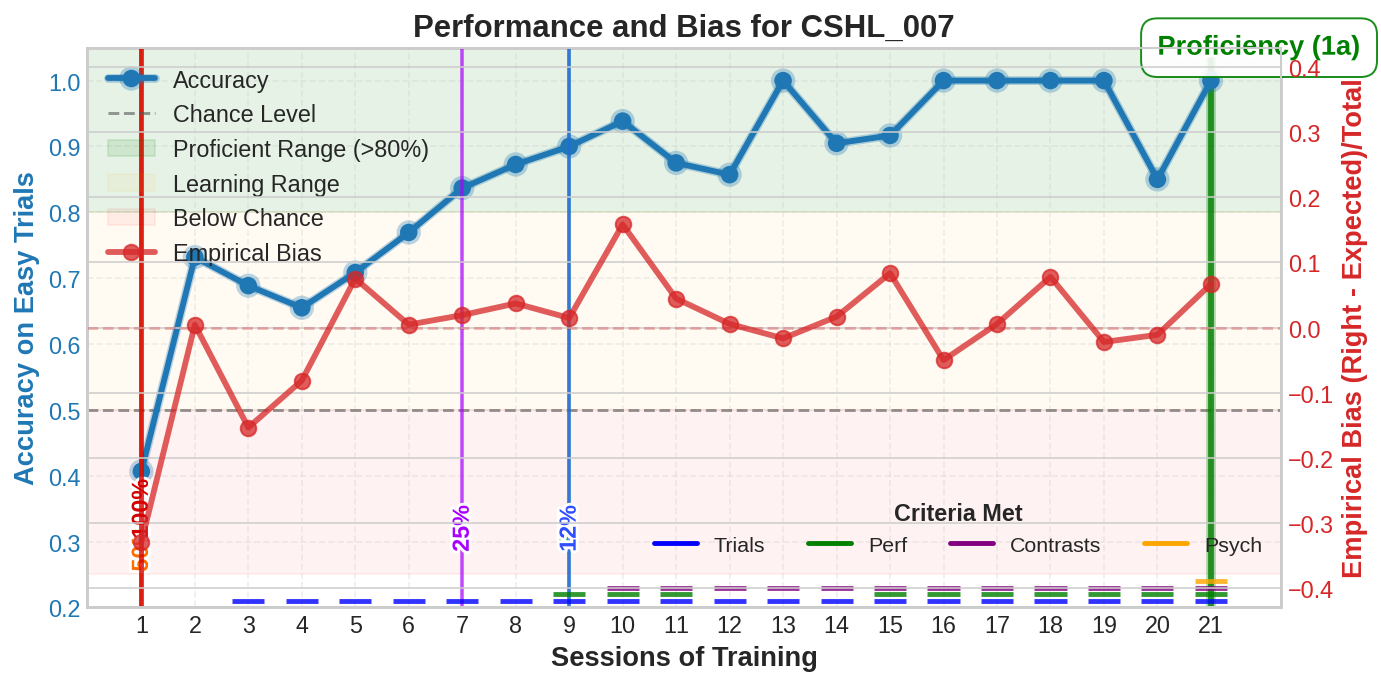

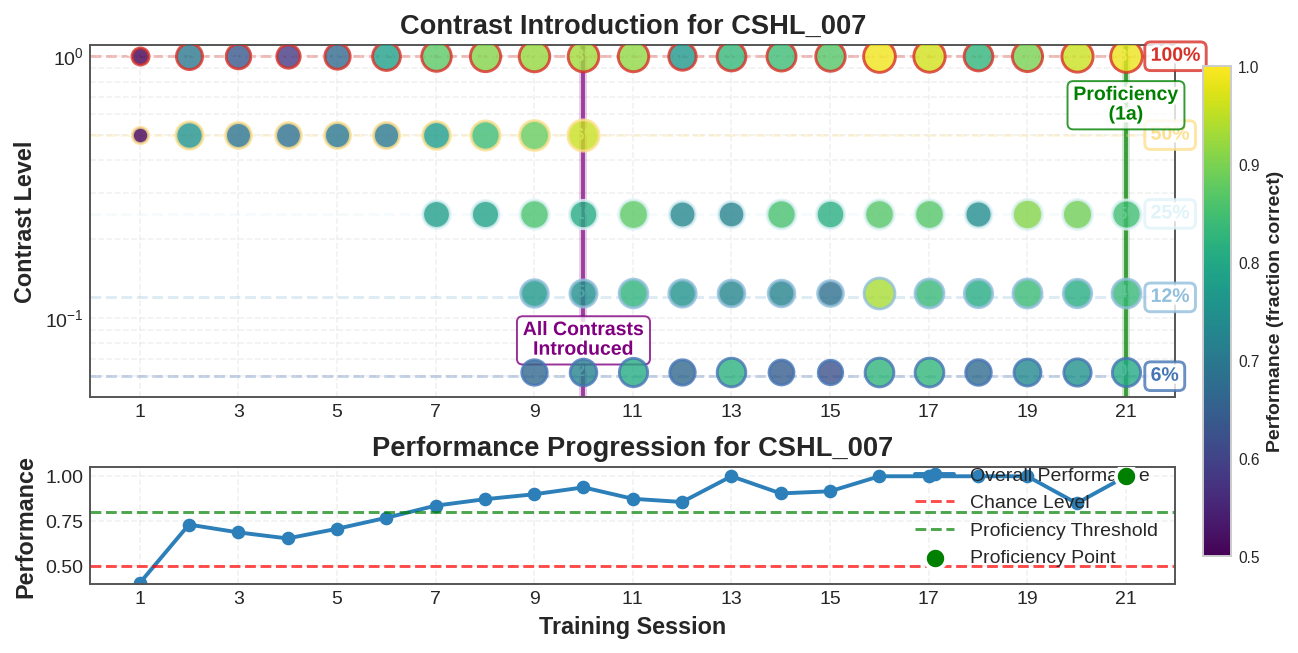

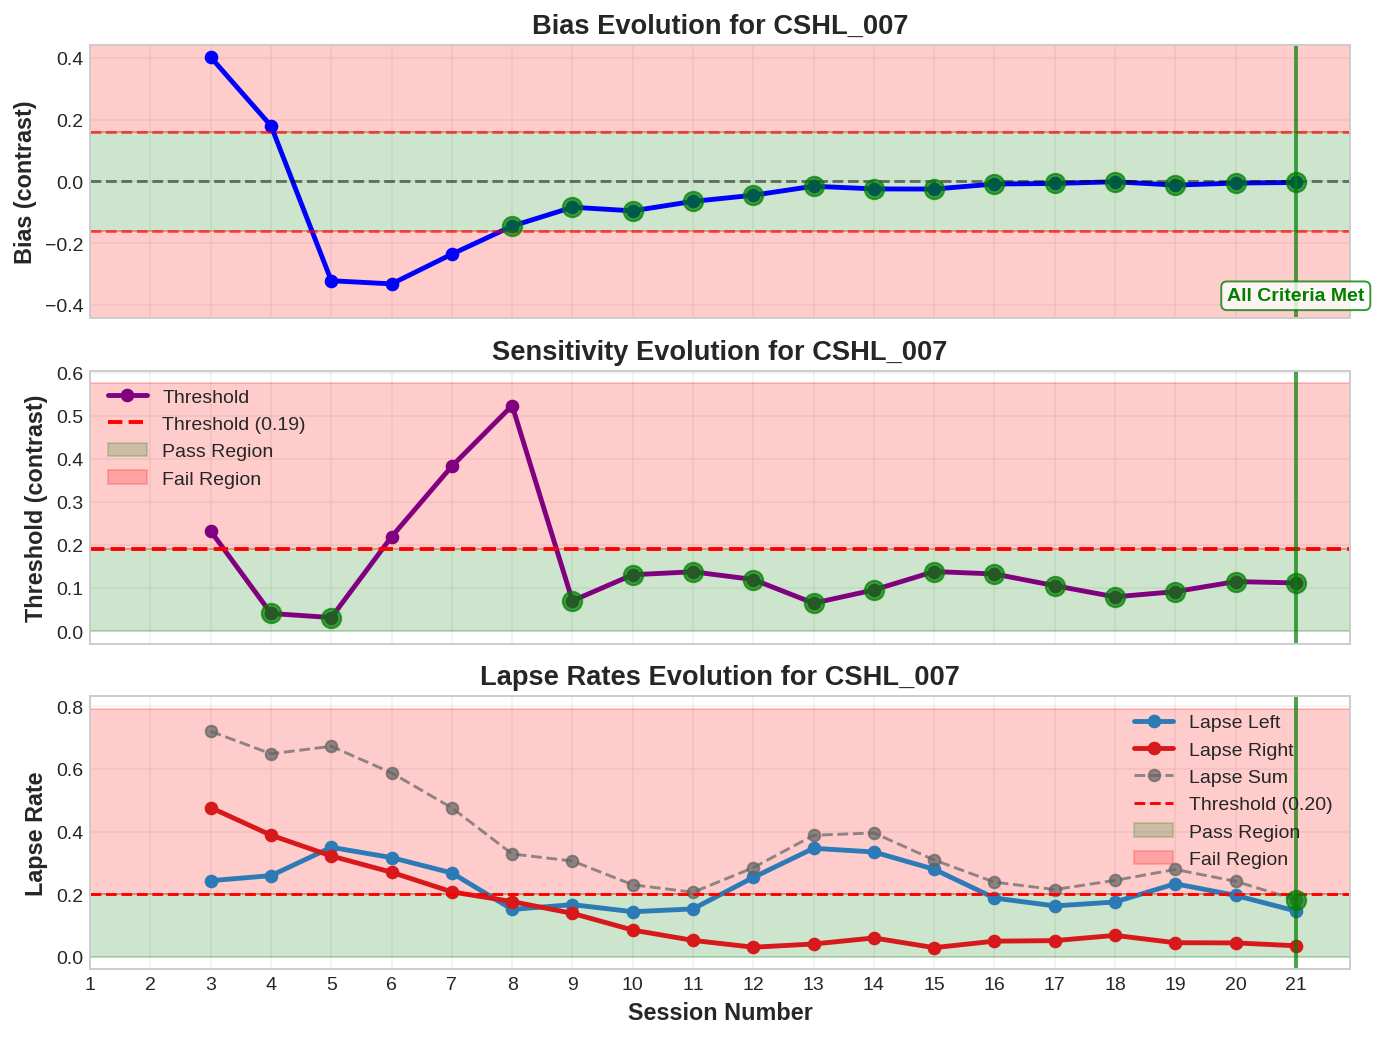

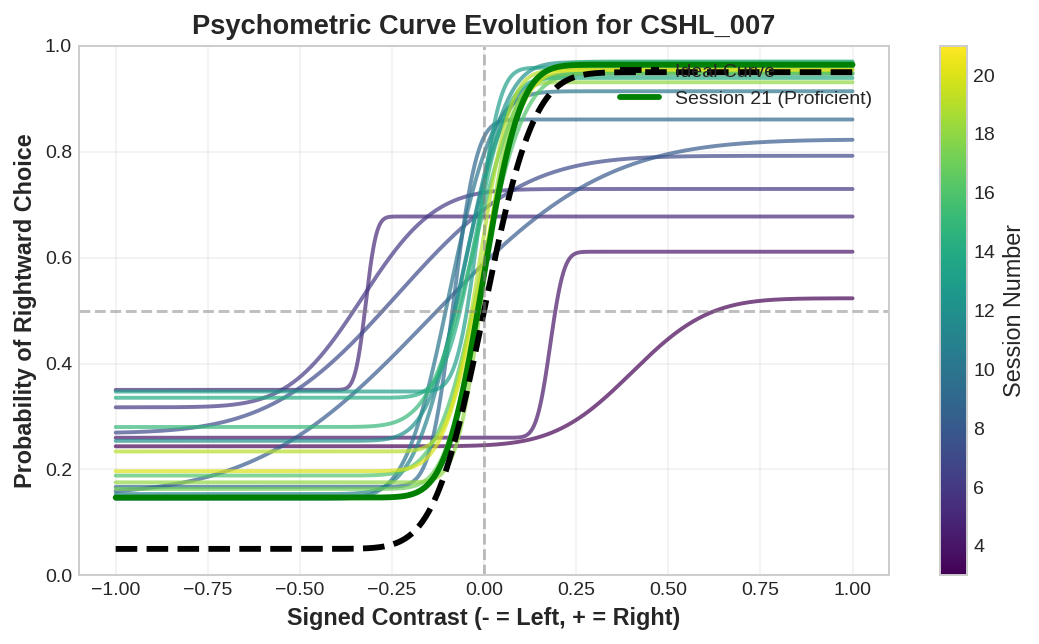

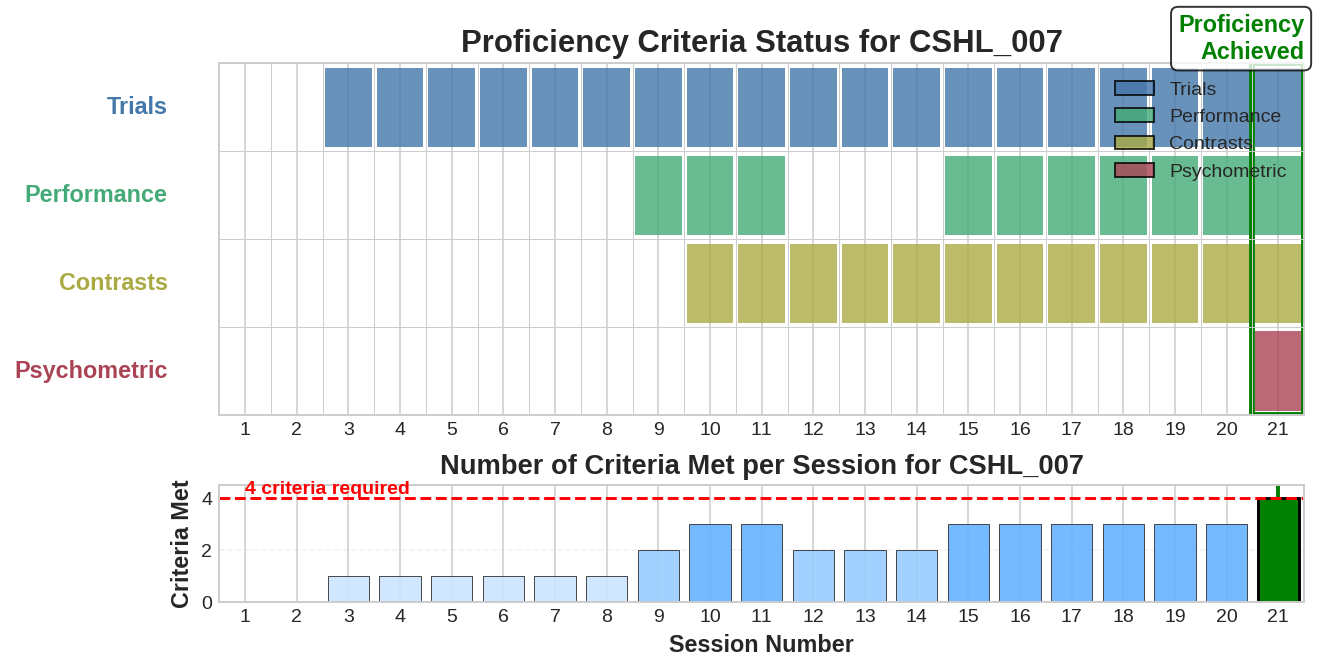

In [ ]:
# Run the analysis on a subject
example_subject = "CSHL_007"  # or any other subject ID in your dataset
results = analyze_basic_task(example_subject, MOUSE_df, SPATH)

# Display summary of results
print("\nSummary of Basic Task Analysis:")
print(f"Subject: {results['subject']}")
print(f"Proficiency reached: {results['proficient']}")
if results['proficient']:
    print(f"Proficiency date: {results['proficiency_date']}")
    print(f"Criteria used: {results['criteria_used']}")
    print(f"Days to proficiency: {results['days_to_proficiency']}")
print(f"Final performance on easy trials: {results['performance'][-1]:.2f}")
print(f"Final empirical bias: {results['empirical_bias'][-1]:.2f}")
print(f"Contrast introduction sequence:")
for session, level in results['contrast_intro_sessions']:
    print(f"  Session {session}: {level*100:.0f}% contrast")


Analyzing subject: CSHL_003
Analyzing basic task performance for subject: CSHL_003
Total number of sessions: 77

Proficiency reached with 1a criteria on date 2019-03-28
Basic task period includes 19 sessions with valid performance data: ['2019-02-25', '2019-02-26', '2019-02-27', '2019-02-28', '2019-03-01', '2019-03-04', '2019-03-05', '2019-03-06', '2019-03-11', '2019-03-12', '2019-03-13', '2019-03-14', '2019-03-15', '2019-03-18', '2019-03-19', '2019-03-20', '2019-03-21', '2019-03-25', '2019-03-28']
First session date: 2019-02-25
Last session date: 2019-03-28
Excluded 3 invalid sessions before proficiency:
  - 3 non-balanced sessions (probL ≠ 0.5): ['2019-03-22', '2019-03-26', '2019-03-27']
Subject: CSHL_003
Proficiency reached: True
Days to proficiency: 19
Final performance: 0.96

Analyzing subject: CSHL_001
Analyzing basic task performance for subject: CSHL_001
Total number of sessions: 78

Proficiency not reached with either criteria
Limiting analysis to first 40 sessions
Basic task

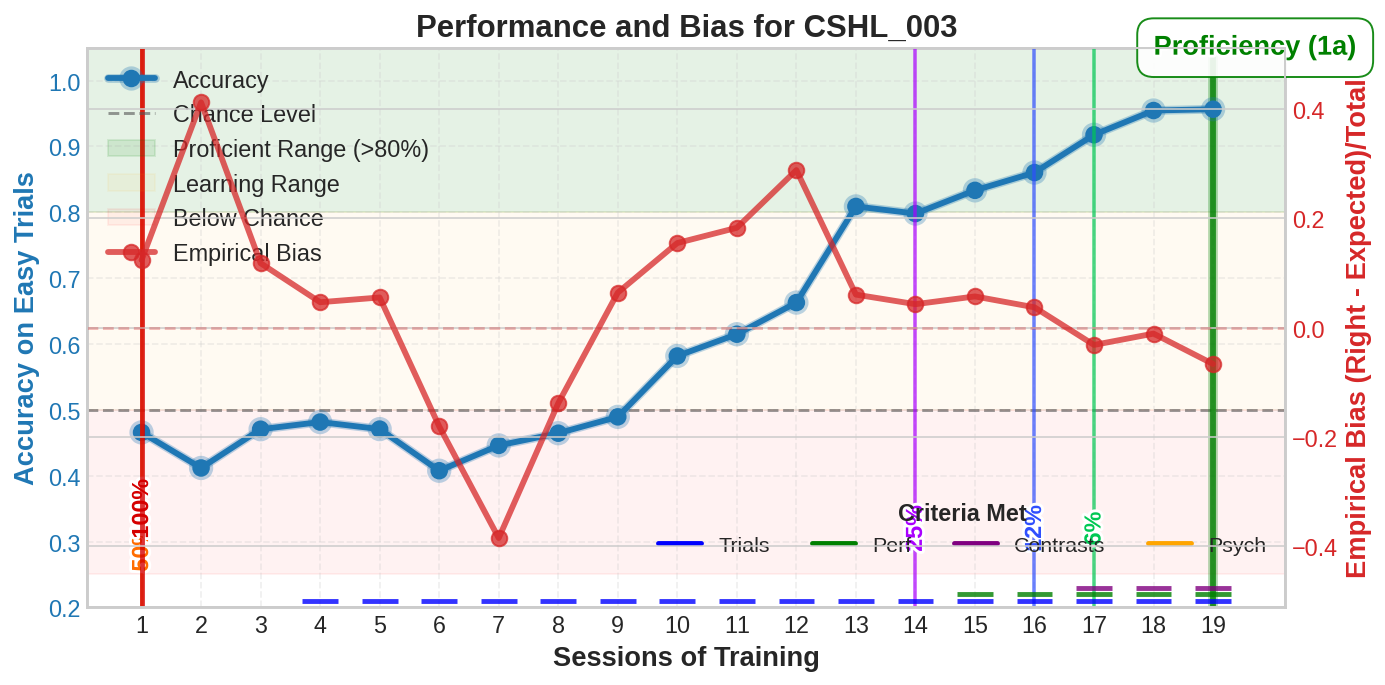

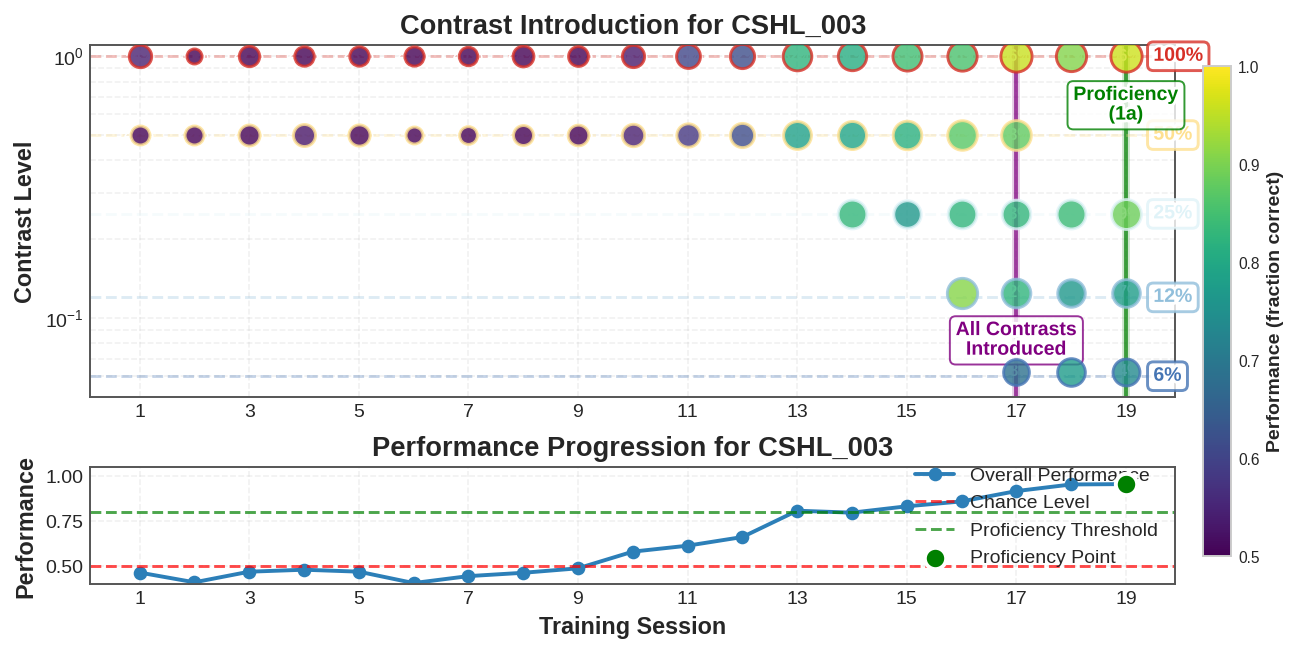

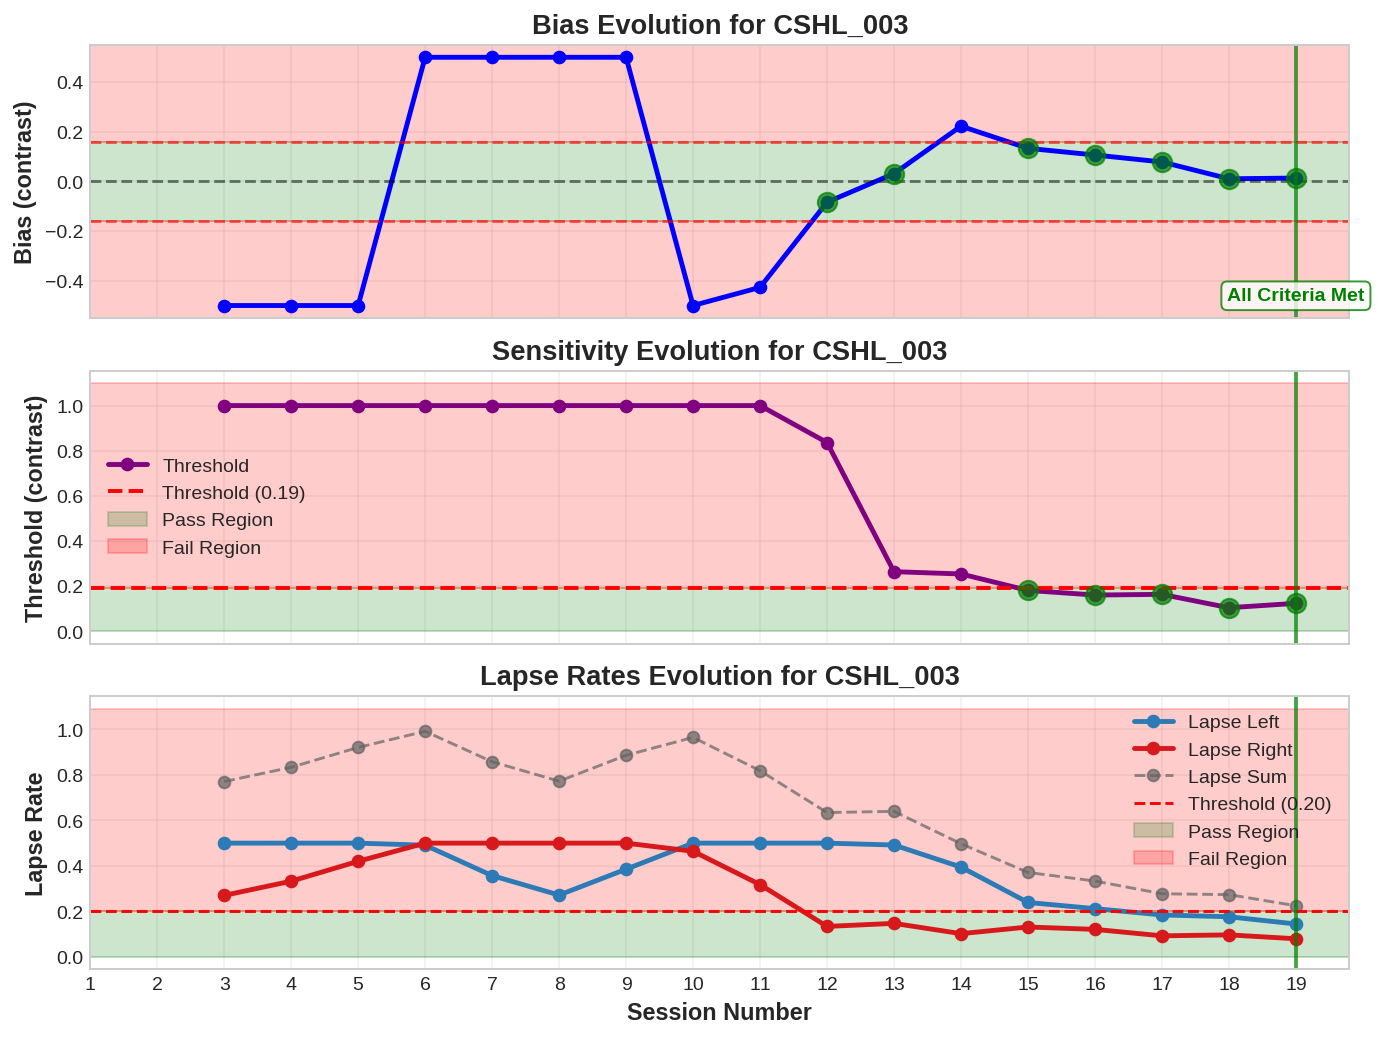

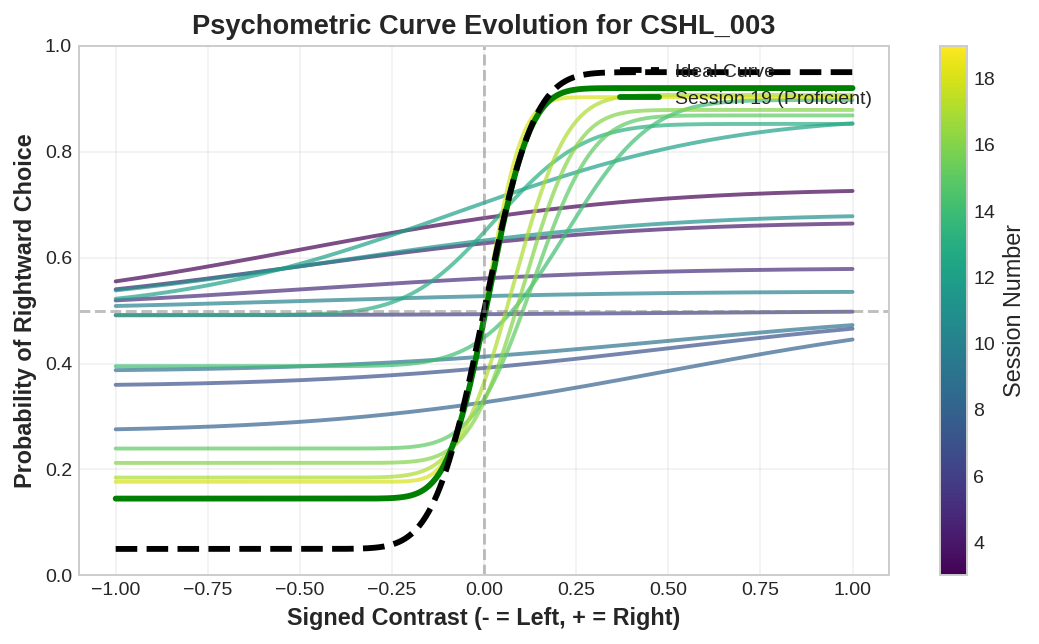

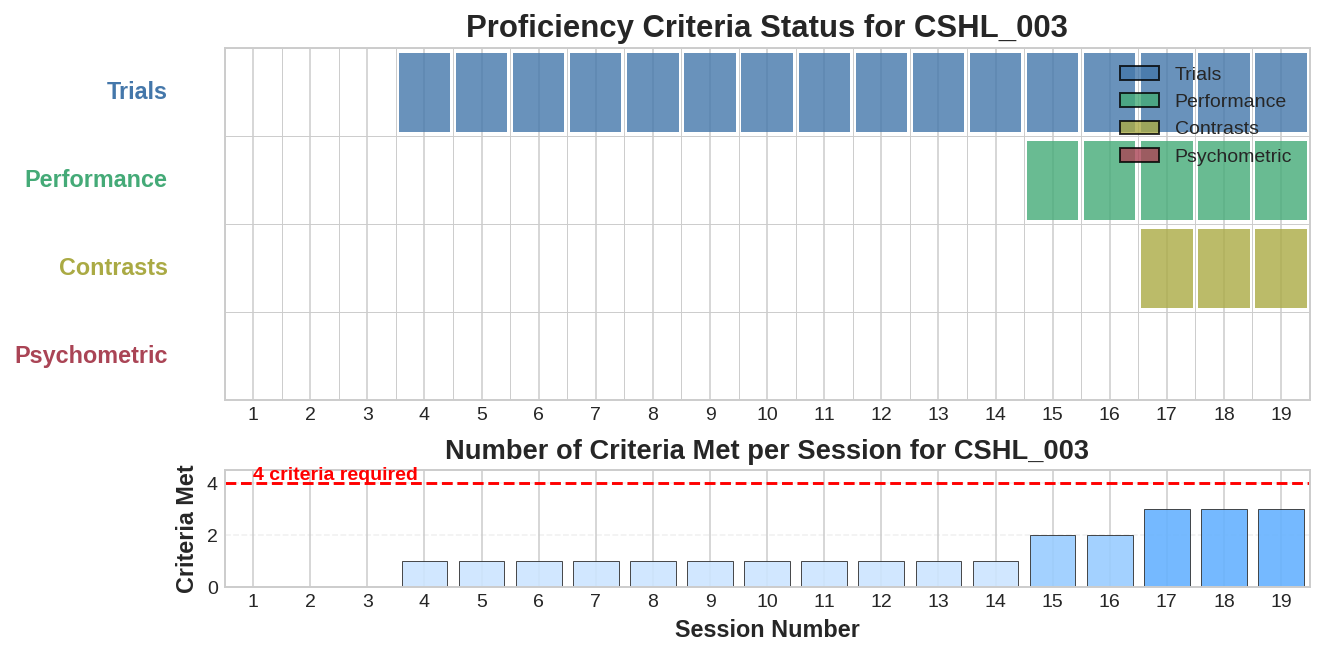

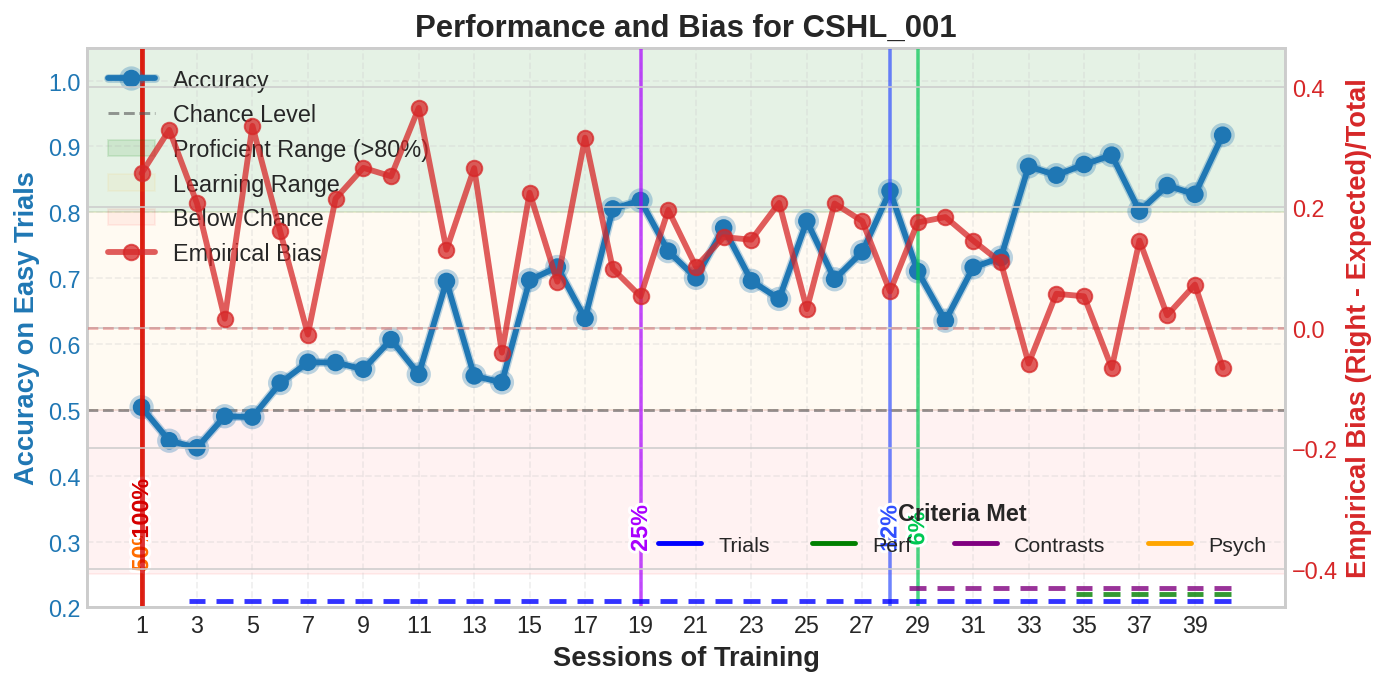

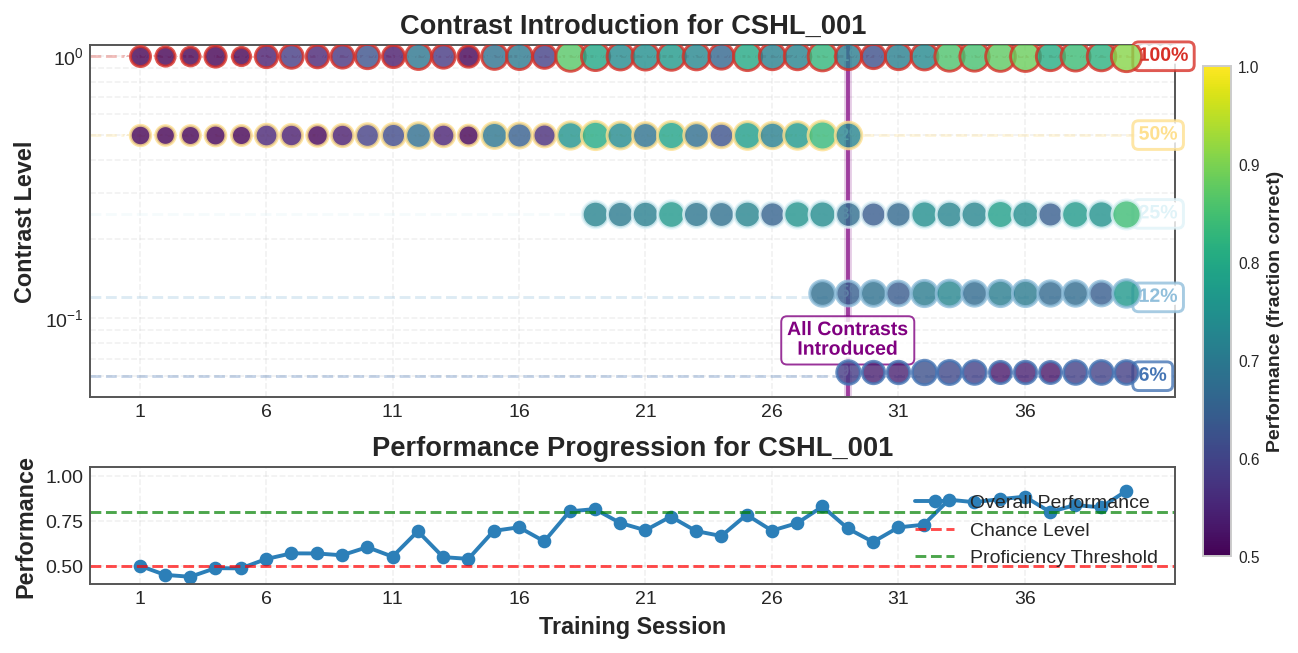

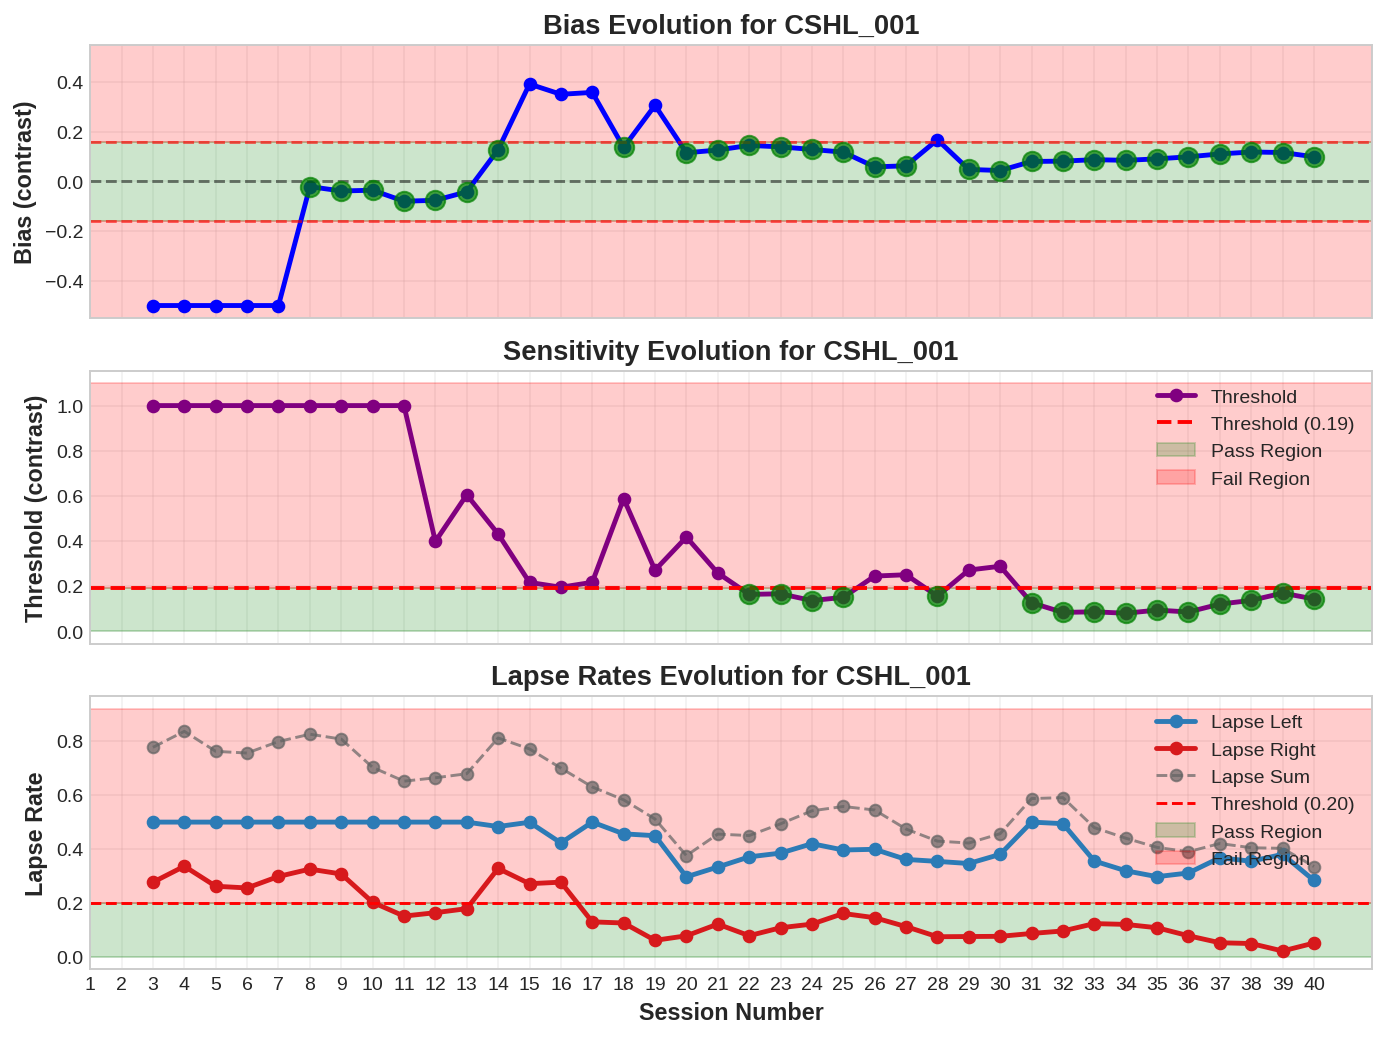

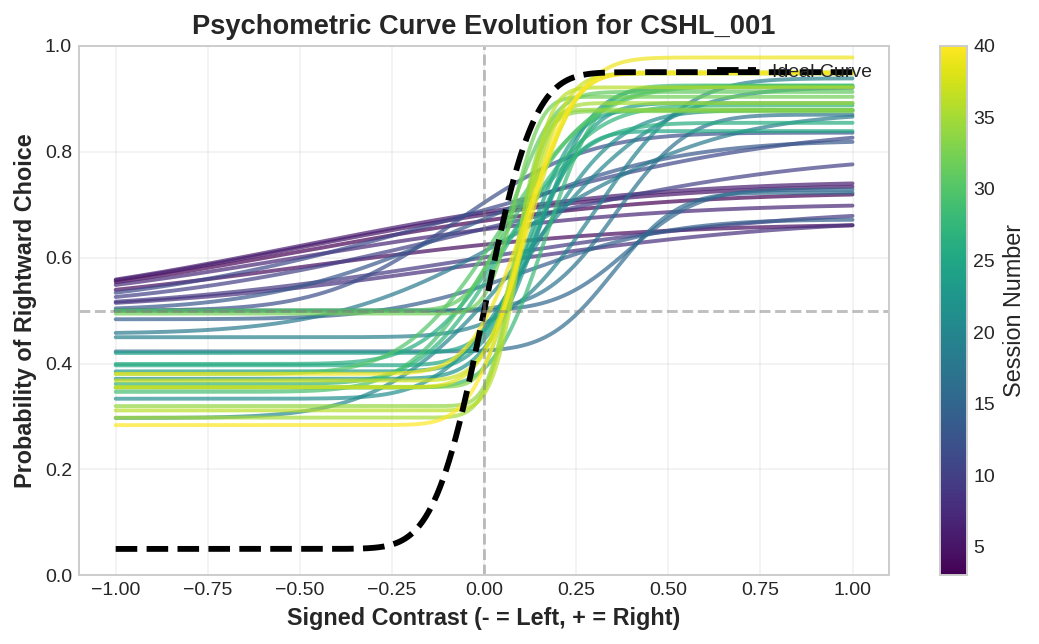

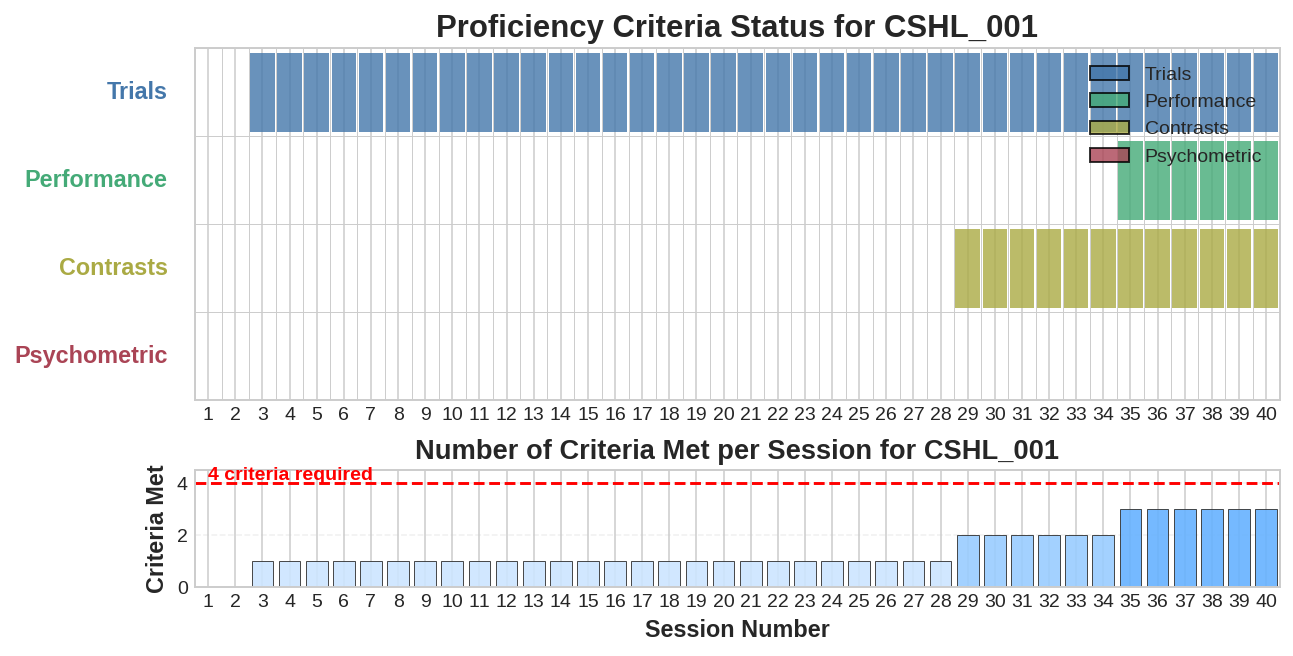

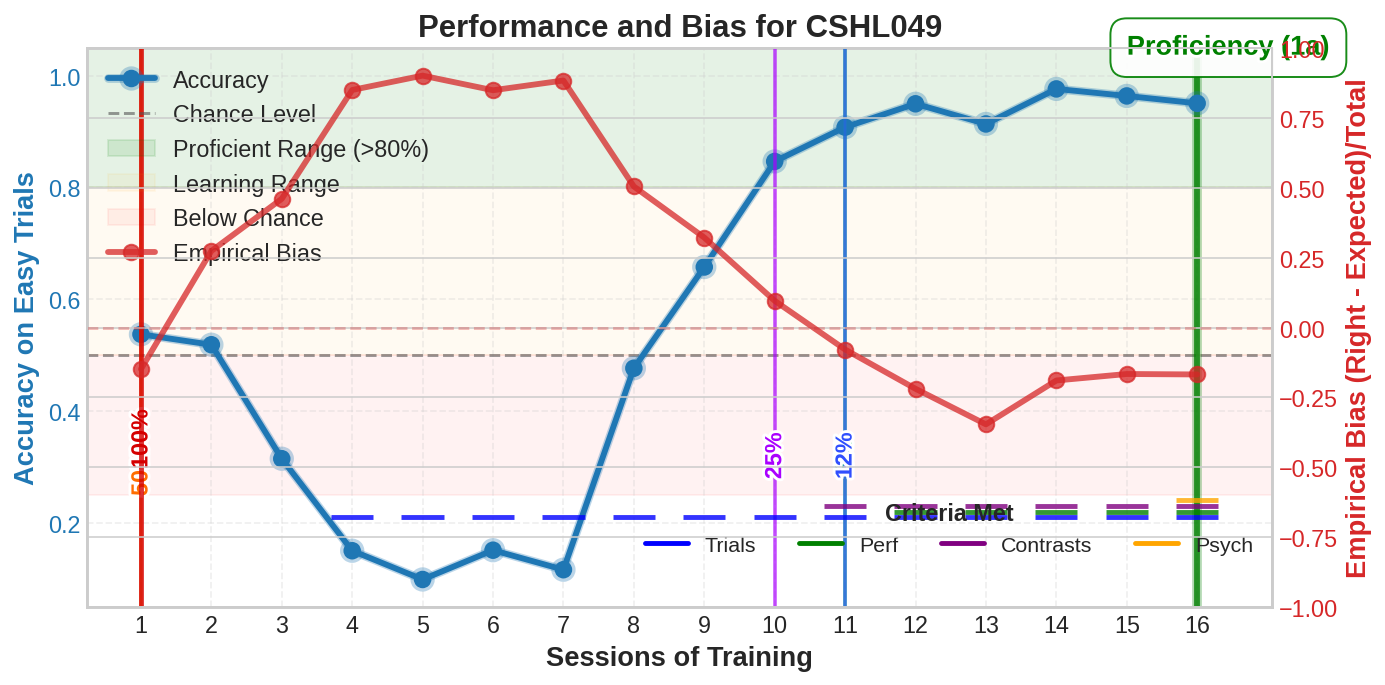

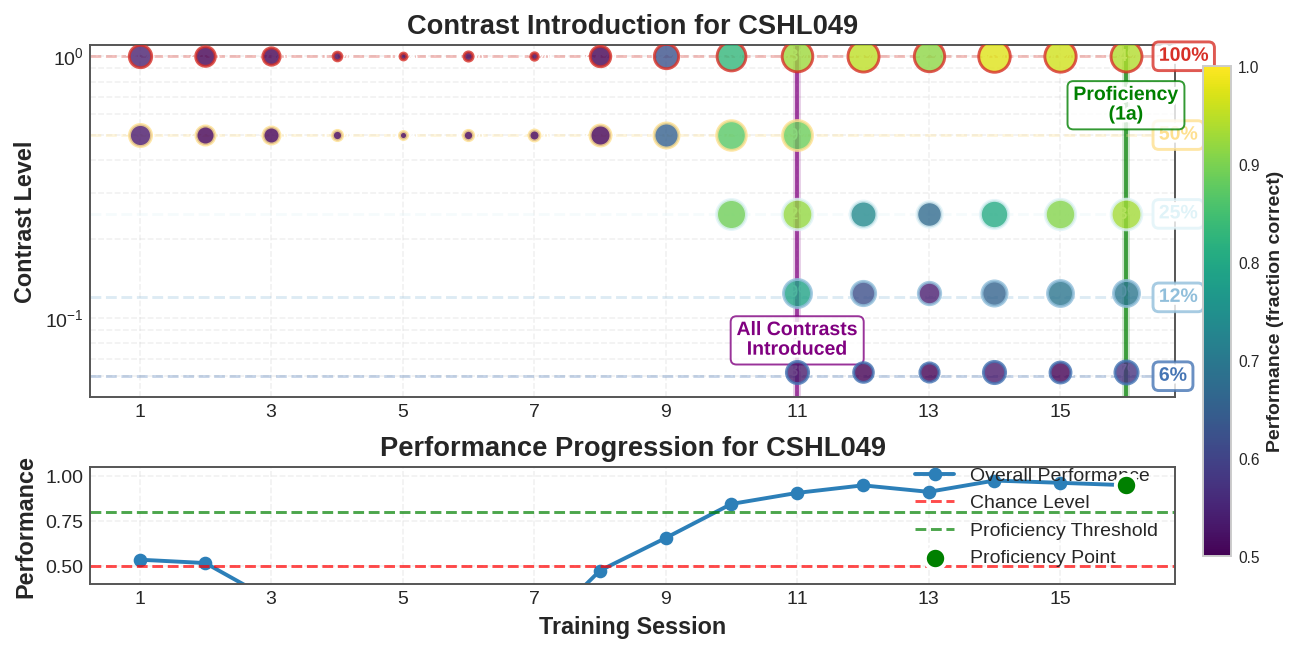

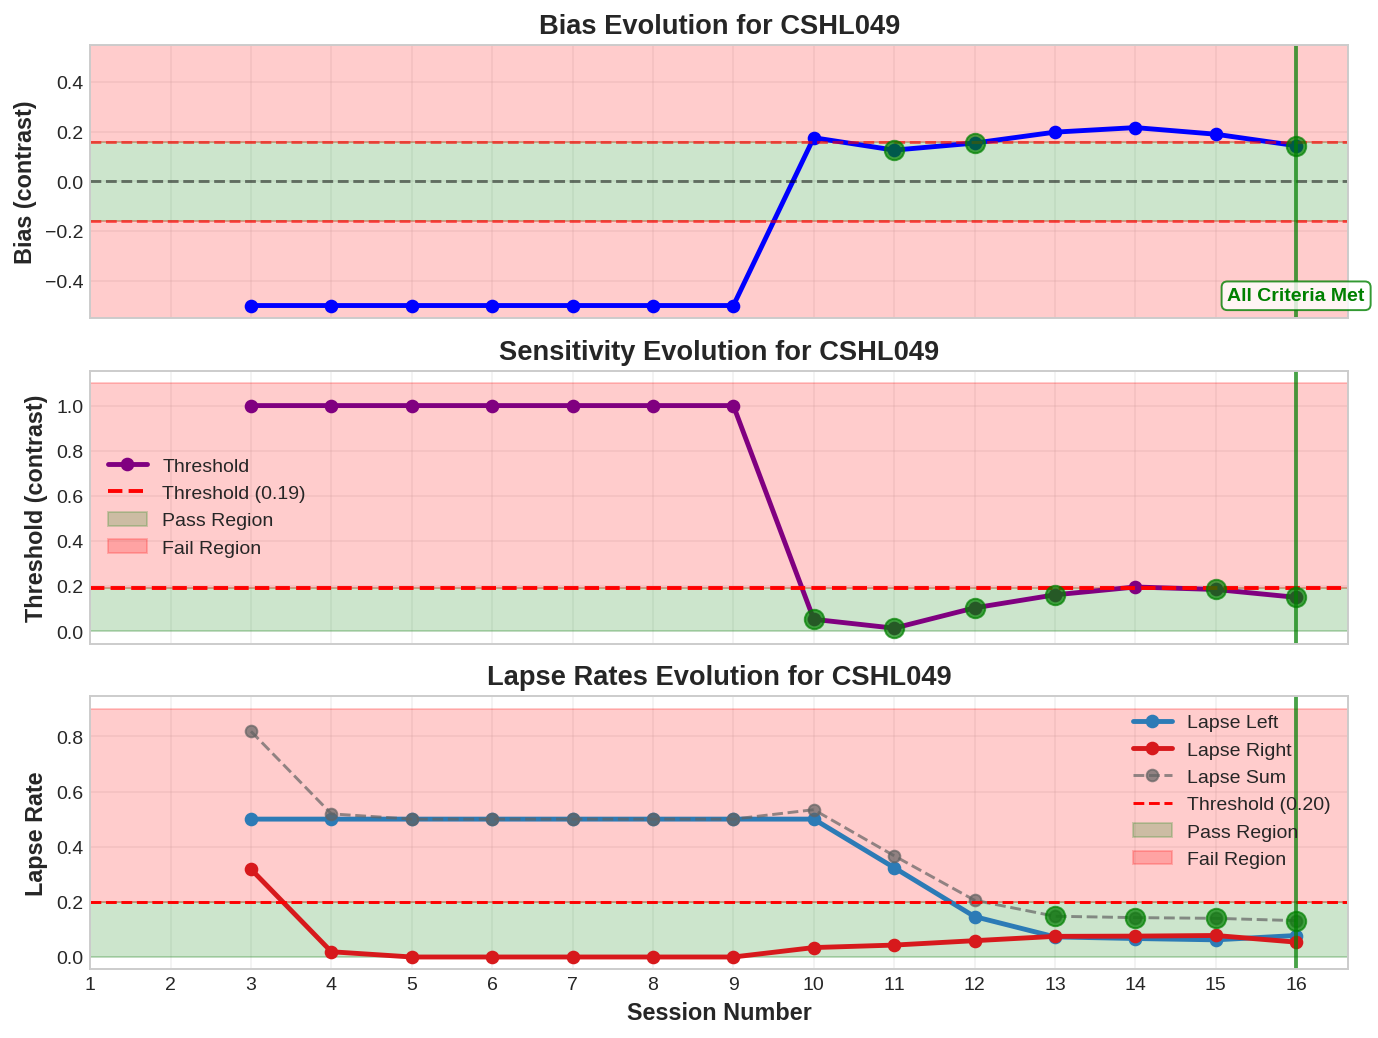

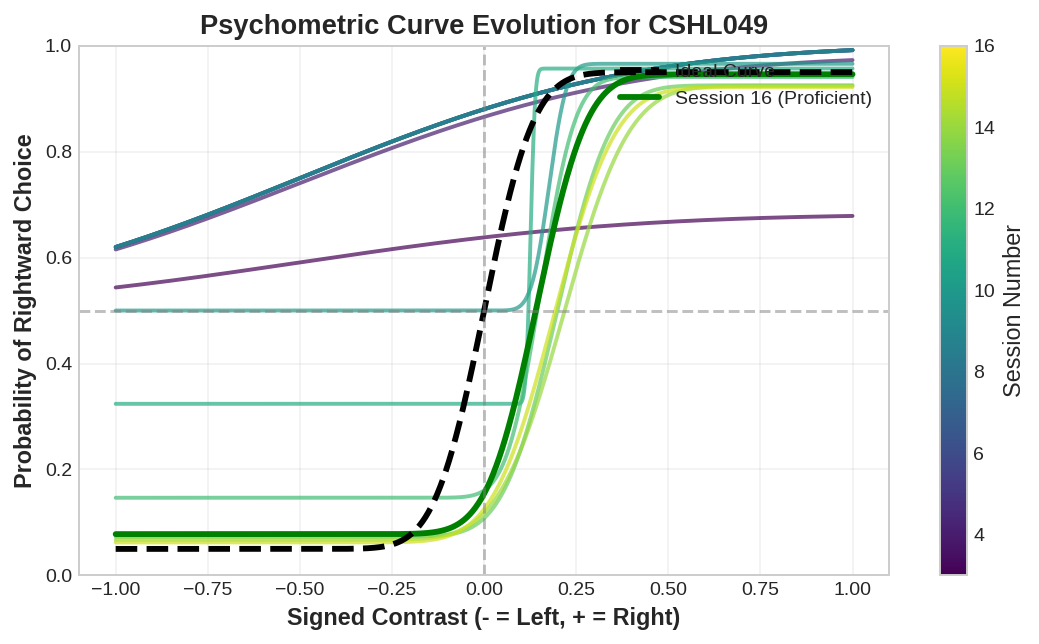

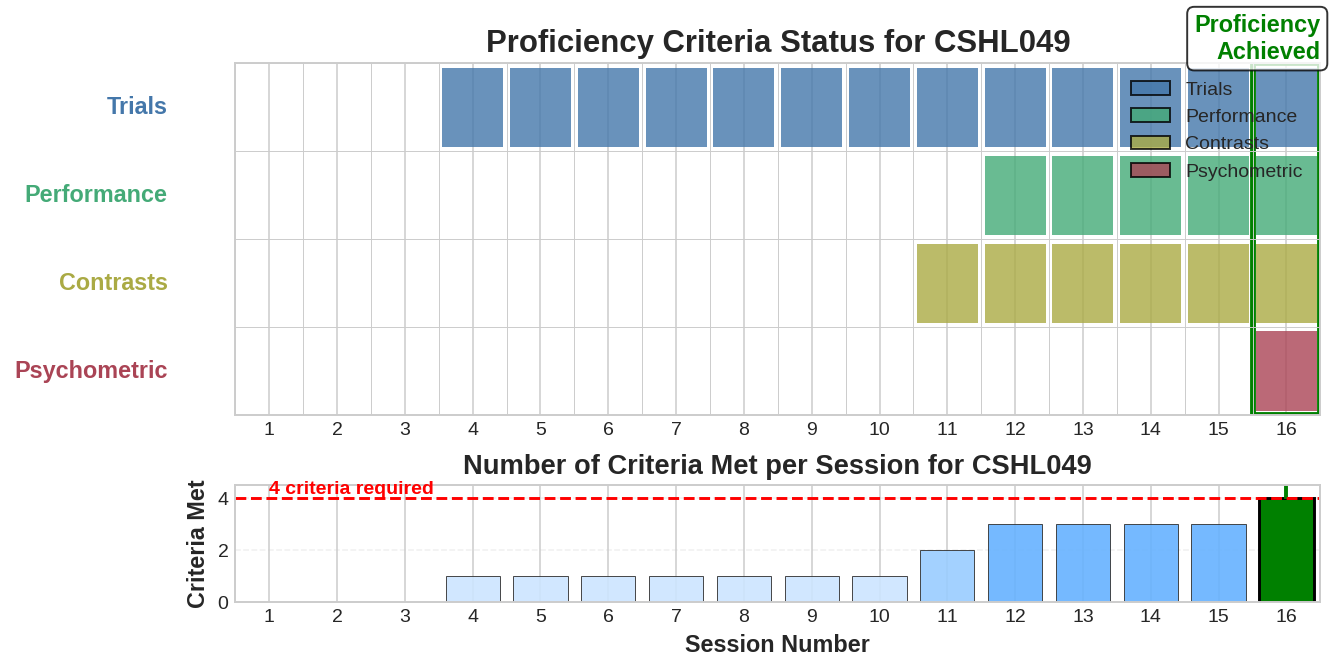

In [ ]:
subjects_to_analyze = ["CSHL_003", "CSHL_001", "CSHL049"]  # List of subjects
all_results = {}

for subject in subjects_to_analyze:
    print(f"\nAnalyzing subject: {subject}")
    results = analyze_basic_task(subject, MOUSE_df, SPATH)
    all_results[subject] = results

    # Display summary
    print(f"Subject: {results['subject']}")
    print(f"Proficiency reached: {results['proficient']}")
    if results['proficient']:
        print(f"Days to proficiency: {results['days_to_proficiency']}")
    print(f"Final performance: {results['performance'][-1]:.2f}")